In [9]:
# -----------------------------------------------------------------------------
# Copyright (c) 2025 Renata Wong
#
# This code is supplementary material for the research paper:
# "Support Vector Machine Kernels as Quantum Propagators"
#
# Licensed under the MIT License.
# You may obtain a copy of the License at: https://opensource.org/licenses/MIT
# -----------------------------------------------------------------------------

import numpy as np
import pandas as pd
from mp_api.client import MPRester
from pymatgen.electronic_structure.core import Spin
from pymatgen.electronic_structure.dos import CompleteDos

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------
API_KEY = "YOUR-API-KEY" 

SEARCH_CRITERIA = {
    "elements": ["Cu"],
    "num_elements": (1, 3),  
    "is_stable": True        
}

# -----------------------------------------------------------------------------
# HELPER: Robust DOS Fetcher
# -----------------------------------------------------------------------------
def get_dos_robust(mpr, material_id):
    """
    Tries to fetch DOS using multiple locations where the method might exist
    in different versions of mp-api.
    """
    # Potential locations for the fetch method
    methods = [
        (mpr, "get_dos_by_material_id"),  # Root (often works for legacy/convenience)
        (getattr(mpr, "electronic_structure", None), "get_dos_by_material_id"),
        (getattr(mpr, "electronic_structure", None), "retrieve"), # Some versions use retrieve
        (getattr(mpr.materials, "electronic_structure", None), "get_dos_by_material_id")
    ]
    
    for obj, method_name in methods:
        if obj and hasattr(obj, method_name):
            try:
                # print(f"  Debug: Trying {method_name} on {type(obj)}")
                result = getattr(obj, method_name)(material_id)
                if result:
                    return result
            except Exception:
                continue
    return None

# -----------------------------------------------------------------------------
# HELPER: Manual Data Extraction (Safe against method errors)
# -----------------------------------------------------------------------------
def extract_dos_at_fermi(dos):
    """
    Manually extracts DOS at Fermi Level by inspecting arrays.
    Handles Pymatgen objects, dictionaries, and wrappers.
    """
    # 1. Standardize to Pymatgen Object if possible
    if isinstance(dos, dict):
        try:
            dos = CompleteDos.from_dict(dos)
        except:
            pass # Keep as dict if conversion fails

    # 2. Extract Energies and Fermi Level
    try:
        # Try attribute access first, then dict access
        efermi = getattr(dos, "efermi", None)
        if efermi is None: efermi = dos.get("efermi")
        
        energies = getattr(dos, "energies", None)
        if energies is None: energies = dos.get("energies")
        
        densities = getattr(dos, "densities", None)
        if densities is None: densities = dos.get("densities")
        
    except Exception as e:
        print(f"  [Parse Error] Could not access attributes: {e}")
        return None

    # 3. Find Index
    if energies is None or densities is None:
        print("  [Parse Error] Energies or Densities missing.")
        return None

    # Find index of energy closest to Fermi level
    idx = np.abs(np.array(energies) - efermi).argmin()

    # 4. Sum Densities (Handle Spin.up/Spin.down or string keys "1"/"-1")
    total_dos = 0.0
    
    # Densities is usually a dict {Spin.up: [...], Spin.down: [...]}
    if isinstance(densities, dict):
        for key, values in densities.items():
            # values is the array of densities
            total_dos += values[idx]
    else:
        # Fallback if it's just a list (unlikely for DOS)
        pass

    return total_dos

# -----------------------------------------------------------------------------
# 1. MAIN LOOP
# -----------------------------------------------------------------------------
print(f"Fetching materials data from Materials Project...")
data_points = []

with MPRester(API_KEY) as mpr:
    # Fetch summary docs
    docs = mpr.materials.summary.search(
        elements=SEARCH_CRITERIA["elements"],
        num_elements=SEARCH_CRITERIA["num_elements"],
        is_stable=SEARCH_CRITERIA["is_stable"],
        fields=["material_id", "band_gap", "density", "is_metal", "formula_pretty"]
    )
    
    print(f"Found {len(docs)} materials.")

    # process a subset or entire docs
    subset_size = len(docs)      
    print(f"Processing first {subset_size} materials...")

    for i, doc in enumerate(docs[:subset_size]):
        try:
            # A. Fetch DOS Object
            dos = get_dos_robust(mpr, doc.material_id)
            
            if dos is None:
                print(f"  [MISSING] DOS not found for {doc.material_id}")
                continue

            # B. Extract Value Manually
            val_dos_ef = extract_dos_at_fermi(dos)
            
            if val_dos_ef is None:
                print(f"  [DATA ERROR] Could not extract numeric value for {doc.material_id}")
                continue

            # C. Compute Features
            eg = doc.band_gap
            rho = doc.density
            kT = 0.02585  # Room temp eV
            
            if doc.is_metal or eg < 0.01:
                sigma_real_proxy = val_dos_ef * rho 
                regime = "Metal"
            else:
                sigma_real_proxy = np.exp(-eg / (2 * kT)) * rho
                regime = "Semiconductor"

            log_sigma = np.log10(sigma_real_proxy + 1e-10)

            data_points.append({
                "Material": doc.formula_pretty,
                "Eg_eV": eg,
                "Density_g_cm3": rho,
                "DOS_at_Ef": val_dos_ef,
                "Conductivity_Proxy": sigma_real_proxy,
                "Log_Sigma": log_sigma,
                "Regime": regime
            })
            
            print(f"  [SUCCESS] {doc.formula_pretty} | DOS(Ef): {val_dos_ef:.4f}")

        except Exception as e:
            print(f"  [ERROR] {doc.material_id}: {e}")
            continue

# -----------------------------------------------------------------------------
# 4. SAVE
# -----------------------------------------------------------------------------
df = pd.DataFrame(data_points)
if not df.empty:
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    print("\n--- DATASET GENERATED ---")
    print(df.head())
    print(f"\nTotal valid samples: {len(df)}")
    df.to_csv("copper_materials_conductivity_proxy.csv", index=False)
    print("Saved to copper_materials_conductivity_proxy.csv")
else:
    print("DataFrame is empty. Please check logs.")

Fetching materials data from Materials Project...


Retrieving SummaryDoc documents: 100%|████| 1086/1086 [00:00<00:00, 2752.80it/s]
/var/folders/3y/5gn0spy50nd0ylhppss8thcc0000gn/T/ipykernel_4734/746957962.py:39: DeprecationWarning: Accessing electronic_structure data through MPRester.electronic_structure is deprecated. Please use MPRester.materials.electronic_structure instead.
  (getattr(mpr, "electronic_structure", None), "get_dos_by_material_id"),
/var/folders/3y/5gn0spy50nd0ylhppss8thcc0000gn/T/ipykernel_4734/746957962.py:40: DeprecationWarning: Accessing electronic_structure data through MPRester.electronic_structure is deprecated. Please use MPRester.materials.electronic_structure instead.
  (getattr(mpr, "electronic_structure", None), "retrieve"), # Some versions use retrieve


Found 1086 materials.
Processing first 1086 materials...


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7752.87it


  [SUCCESS] Cu | DOS(Ef): 0.3054


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7397.36it


  [MISSING] DOS not found for mp-2360071


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9157.87it


  [SUCCESS] AlCu | DOS(Ef): 2.0930


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6678.83it


  [SUCCESS] CuCl2 | DOS(Ef): 1.3342


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8559.80it


  [SUCCESS] CuI4 | DOS(Ef): 8.8901


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [SUCCESS] Ga2Cu | DOS(Ef): 0.8119


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8943.08it


  [SUCCESS] CuAu | DOS(Ef): 0.6116


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6955.73it


  [SUCCESS] TiCu | DOS(Ef): 2.7167


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] CuO | DOS(Ef): 2.3132


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8774.69it


  [SUCCESS] Zr2Cu | DOS(Ef): 1.5787


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9446.63it


  [SUCCESS] Hf2Cu | DOS(Ef): 1.2992


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9177.91it


  [SUCCESS] Ti2Cu | DOS(Ef): 1.3871


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] CuF2 | DOS(Ef): 2.0540


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6452.78it


  [SUCCESS] CuP2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11618.57i


  [SUCCESS] CuI | DOS(Ef): 0.0055


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6288.31it


  [SUCCESS] CuPt | DOS(Ef): 0.8162


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6492.73it


  [SUCCESS] SrCu | DOS(Ef): 3.6685


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9642.08it


  [SUCCESS] BaCu | DOS(Ef): 3.2649


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10951.19i


  [SUCCESS] Zn3Cu | DOS(Ef): 1.7870


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7002.18it


  [SUCCESS] CuP10 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9597.95it


  [SUCCESS] CuBr | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] CuPd | DOS(Ef): 1.5277


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [SUCCESS] ScCu | DOS(Ef): 1.3083


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7206.71it


  [SUCCESS] TbCu | DOS(Ef): 1.0838


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 5433.04it


  [SUCCESS] ErCu | DOS(Ef): 0.9881


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11491.24i


  [SUCCESS] HoCu | DOS(Ef): 1.0079


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6374.32it


  [SUCCESS] DyCu | DOS(Ef): 1.0305


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9177.91it


  [SUCCESS] TmCu | DOS(Ef): 0.9632


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9425.40it


  [SUCCESS] ZnCu | DOS(Ef): 0.5070


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10010.27i


  [SUCCESS] CuPt7 | DOS(Ef): 11.2213


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8630.26it


  [SUCCESS] Al2Cu | DOS(Ef): 0.8751


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8701.88it


  [SUCCESS] Be2Cu | DOS(Ef): 0.8820


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7084.97it


  [SUCCESS] CuSe2 | DOS(Ef): 3.0819


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9986.44it


  [SUCCESS] CuTe | DOS(Ef): 1.7067


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8701.88it


  [SUCCESS] LaCu | DOS(Ef): 1.2766


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8924.05it


  [SUCCESS] PrCu | DOS(Ef): 7.5263


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9642.08it


  [SUCCESS] YCu | DOS(Ef): 5.4888


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10837.99i


  [SUCCESS] EuCu | DOS(Ef): 4.7367


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] Ca2Cu | DOS(Ef): 9.3575


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 2563.76it


  [SUCCESS] NdCu | DOS(Ef): 3.0503


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8004.40it


  [SUCCESS] YbCu | DOS(Ef): 3.7605


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10082.46i


  [SUCCESS] CaCu | DOS(Ef): 19.1828


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8542.37it


  [SUCCESS] SmCu | DOS(Ef): 2.6353


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 27962.03i


  [SUCCESS] CuS | DOS(Ef): 3.5574


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] CuSe | DOS(Ef): 4.0644


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] Mg2Cu | DOS(Ef): 3.5130


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7307.15it


  [MISSING] DOS not found for mp-1217600


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8559.80it


  [SUCCESS] Cu(PtS2)2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8830.11it


  [MISSING] DOS not found for mp-1195070


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6668.21it


  [SUCCESS] NdAl3Cu | DOS(Ef): 1.3350


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8867.45it


  [SUCCESS] CeAl3Cu | DOS(Ef): 8.6946


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] PrAl3Cu | DOS(Ef): 1.3555


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8405.42it


  [SUCCESS] LaAl3Cu | DOS(Ef): 1.4551


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7194.35it


  [SUCCESS] GdAl3Cu | DOS(Ef): 1.5052


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [SUCCESS] TiCuNi | DOS(Ef): 1.6629


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10106.76i


  [SUCCESS] SmAl3Cu | DOS(Ef): 1.2753


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [MISSING] DOS not found for mp-1224113


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7639.90it


  [SUCCESS] CuAuSe4 | DOS(Ef): 0.1259


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8924.05it


  [SUCCESS] Cu(IO3)2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] CuReO4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] In5CuSe8 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] AlCuBr4 | DOS(Ef): 0.1085


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9686.61it


  [MISSING] DOS not found for mp-1212660


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8338.58it


  [SUCCESS] AlCuCl4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9799.78it


  [SUCCESS] GaCuCl4 | DOS(Ef): 1.0385


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9986.44it


  [SUCCESS] Eu2CuTe4 | DOS(Ef): 3.6045


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] YbGa3Cu | DOS(Ef): 1.8339


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10034.22i


  [SUCCESS] SmGa3Cu | DOS(Ef): 1.2746


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12192.74i


  [SUCCESS] NdGa3Cu | DOS(Ef): 1.8050


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6754.11it


  [SUCCESS] LaGa3Cu | DOS(Ef): 2.7465


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7928.74it


  [SUCCESS] EuGa3Cu | DOS(Ef): 2.1887


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6898.53it


  [SUCCESS] DyGa3Cu | DOS(Ef): 1.0709


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10645.44i


  [SUCCESS] CeGa3Cu | DOS(Ef): 3.7194


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9532.51it


  [SUCCESS] Hf4CuSi4 | DOS(Ef): 3.5131


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13706.88i


  [MISSING] DOS not found for mp-1219296


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6574.14it


  [SUCCESS] ScCuSe2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7752.87it


  [MISSING] DOS not found for mp-1225663


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9238.56it


  [SUCCESS] NaCuO2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7244.05it


  [SUCCESS] MnCuO2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8542.37it


  [MISSING] DOS not found for mp-9158


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11096.04i


  [SUCCESS] CuAuO2 | DOS(Ef): 2.0515


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7108.99it


  [SUCCESS] CuBS2 | DOS(Ef): 0.0004


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9731.56it


  [SUCCESS] TlCuSe2 | DOS(Ef): 0.2133


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11618.57i


  [SUCCESS] InCuTe2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] InCuS2 | DOS(Ef): 0.3561


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7037.42it


  [SUCCESS] InCuSe2 | DOS(Ef): 0.0834


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [SUCCESS] GaCuTe2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10407.70i


  [SUCCESS] GaCuSe2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10010.27i


  [SUCCESS] Cu(BO2)2 | DOS(Ef): 5.3638


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9446.63it


  [SUCCESS] AlCuS2 | DOS(Ef): 0.0815


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9510.89it


  [SUCCESS] GaCuS2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8774.69it


  [SUCCESS] AlCuSe2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [SUCCESS] AlCuTe2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9597.95it


  [SUCCESS] Ti4CuAg | DOS(Ef): 3.9679


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] Tb2CuAg | DOS(Ef): 2.0592


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9532.51it


  [SUCCESS] AlCuPt2 | DOS(Ef): 0.7504


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10106.76i


  [SUCCESS] SrCuO2 | DOS(Ef): 0.9448


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [SUCCESS] GaCuPt2 | DOS(Ef): 0.7424


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] Ce2Ga12Cu | DOS(Ef): 20.5650


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10082.46i


  [SUCCESS] LaCuSb2 | DOS(Ef): 3.1564


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10180.35i


  [SUCCESS] SmCuSb2 | DOS(Ef): 2.7701


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] LuCuSb2 | DOS(Ef): 2.6593


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] HfCuGe2 | DOS(Ef): 3.4599


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] ZrCuGe2 | DOS(Ef): 3.7863


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [SUCCESS] YCuAs2 | DOS(Ef): 1.8277


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [SUCCESS] DyCuAs2 | DOS(Ef): 1.7918


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9731.56it


  [SUCCESS] ErCuAs2 | DOS(Ef): 1.7863


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9425.40it


  [SUCCESS] TmCuAs2 | DOS(Ef): 1.7315


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] BaCuS2 | DOS(Ef): 3.8319


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8774.69it


  [SUCCESS] PrCuSb2 | DOS(Ef): 2.6902


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7810.62it


  [SUCCESS] NdCuSb2 | DOS(Ef): 2.8313


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 5461.33it


  [SUCCESS] GdCuAs2 | DOS(Ef): 2.0466


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8542.37it


  [SUCCESS] HfCuSi2 | DOS(Ef): 3.1019


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] GdCuSb2 | DOS(Ef): 3.0340


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9425.40it


  [SUCCESS] DyCuSb2 | DOS(Ef): 2.5038


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7049.25it


  [SUCCESS] HoCuSb2 | DOS(Ef): 2.5221


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10512.04i


  [SUCCESS] HoCuAs2 | DOS(Ef): 1.8070


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11335.96i


  [SUCCESS] TbCuSb2 | DOS(Ef): 2.5964


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10512.04i


  [SUCCESS] YbCuAs2 | DOS(Ef): 4.0297


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10538.45i


  [SUCCESS] CeCuSb2 | DOS(Ef): 12.2608


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9822.73it


  [SUCCESS] TbCuAs2 | DOS(Ef): 1.7774


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10512.04i


  [SUCCESS] Cu(BiO2)2 | DOS(Ef): 31.3300


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10082.46i


  [SUCCESS] CuPS3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 5023.12it


  [SUCCESS] Li3CuO3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [MISSING] DOS not found for mp-755401


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8924.05it


  [SUCCESS] Rb2CuF4 | DOS(Ef): 0.8824


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7002.18it


  [SUCCESS] Cs2CuF4 | DOS(Ef): 1.0357


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10894.30i


  [SUCCESS] Tl2CuF4 | DOS(Ef): 1.1156


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8004.40it


  [SUCCESS] HfCuGe | DOS(Ef): 1.5844


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] La2CuO4 | DOS(Ef): 2.3406


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7869.24it


  [MISSING] DOS not found for mp-2042825


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7194.35it


  [SUCCESS] Pr2CuO4 | DOS(Ef): 0.7549


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8774.69it


  [SUCCESS] Gd2CuO4 | DOS(Ef): 3.1703


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11781.75i


  [SUCCESS] LiCuO | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9822.73it


  [SUCCESS] NaCuO | DOS(Ef): 1.1737


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8272.79it


  [SUCCESS] RbCuO | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 2801.81it


  [SUCCESS] Sr2CuO4 | DOS(Ef): 4.3400


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8405.42it


  [SUCCESS] KCuO | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9776.93it


  [SUCCESS] NdCuS2 | DOS(Ef): 0.6231


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12633.45i


  [SUCCESS] LaCuSe2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8612.53it


  [SUCCESS] PrCuSe2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 21183.35i


  [SUCCESS] SmCuSe2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9892.23it


  [MISSING] DOS not found for mp-1188790


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 5592.41it


  [MISSING] DOS not found for mp-1210463


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11748.75i


  [SUCCESS] MnCuSe4 | DOS(Ef): 6.2662


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8756.38it


  [SUCCESS] TbCuSe2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10837.99i


  [MISSING] DOS not found for mp-1337320


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7516.67it


  [MISSING] DOS not found for mp-1369804


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7307.15it


  [SUCCESS] PrCuS2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8388.61it


  [SUCCESS] KCuCl3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [MISSING] DOS not found for mp-2763763


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] Rb3CuO2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8192.00it


  [SUCCESS] Ga2CuCl8 | DOS(Ef): 1.8588


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10407.70i


  [SUCCESS] CuSe2Br | DOS(Ef): 0.4669


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10866.07i


  [SUCCESS] CuTe2Cl | DOS(Ef): 0.3754


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9822.73it


  [SUCCESS] CuTe2Br | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] CuTe2I | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] CuSe2Cl | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 16448.25i


  [SUCCESS] La2CuS4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10837.99i


  [SUCCESS] Na2CuF4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10407.70i


  [SUCCESS] NdCuSe2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8612.53it


  [SUCCESS] LaCuS2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10082.46i


  [MISSING] DOS not found for mp-504265


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10979.85i


  [SUCCESS] SmCuS2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8338.58it


  [SUCCESS] GdCuS2 | DOS(Ef): 1.1353


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10645.44i


  [SUCCESS] GdCuSe2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 19599.55i


  [SUCCESS] TbCuS2 | DOS(Ef): 0.8200


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [SUCCESS] CeCuS2 | DOS(Ef): 0.3712


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [SUCCESS] SrCuF4 | DOS(Ef): 2.4971


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8192.00it


  [SUCCESS] CaCuF4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12300.01i


  [SUCCESS] KCuF3 | DOS(Ef): 2.3529


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11781.75i


  [SUCCESS] RbCuF3 | DOS(Ef): 3.3074


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8144.28it


  [SUCCESS] CdCuF4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7584.64it


  [SUCCESS] Li2CuSn2 | DOS(Ef): 1.4333


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9986.44it


  [MISSING] DOS not found for mp-1404142


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9020.01it


  [SUCCESS] Cu(PO3)2 | DOS(Ef): 19.9587


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8388.61it


  [SUCCESS] BaCuN | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7463.17it


  [SUCCESS] CuSe2O5 | DOS(Ef): 0.5398


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9799.78it


  [SUCCESS] LuCuS2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8848.74it


  [SUCCESS] Y2Ga3Cu | DOS(Ef): 1.4305


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9915.61it


  [SUCCESS] Tm2Ga3Cu | DOS(Ef): 1.1231


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7884.03it


  [MISSING] DOS not found for mp-1217694


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8256.50it


  [SUCCESS] Sm2Ga3Cu | DOS(Ef): 1.1886


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6808.94it


  [SUCCESS] Lu2Ga3Cu | DOS(Ef): 1.1342


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10645.44i


  [SUCCESS] Ho2Ga3Cu | DOS(Ef): 1.1310


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10180.35i


  [SUCCESS] Dy2Ga3Cu | DOS(Ef): 1.1474


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8559.80it


  [SUCCESS] Er2Ga3Cu | DOS(Ef): 1.1493


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12985.46i


  [SUCCESS] DyCuSe2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9446.63it


  [SUCCESS] ScCuS2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7307.15it


  [MISSING] DOS not found for mp-1224607


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7570.95it


  [SUCCESS] Hf2Al3Cu | DOS(Ef): 5.3677


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9532.51it


  [SUCCESS] PrCuO2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10381.94i


  [SUCCESS] SmCuO2 | DOS(Ef): 0.2002


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [SUCCESS] CuRhO2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9776.93it


  [SUCCESS] LaCuO2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7463.17it


  [SUCCESS] NdCuO2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6808.94it


  [SUCCESS] FeCuO2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8701.88it


  [SUCCESS] CrCuO2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10082.46i


  [SUCCESS] LaCuO3 | DOS(Ef): 2.2134


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10645.44i


  [MISSING] DOS not found for mp-23032


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9177.91it


  [MISSING] DOS not found for mp-1222193


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8701.88it


  [SUCCESS] HfCuSn | DOS(Ef): 2.0546


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10106.76i


  [SUCCESS] HoCuSn | DOS(Ef): 0.7731


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10407.70i


  [SUCCESS] LaCuPb | DOS(Ef): 0.8293


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] CeCuPb | DOS(Ef): 1.7034


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10727.12i


  [SUCCESS] TbCuSn | DOS(Ef): 0.8124


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10645.44i


  [SUCCESS] ErCuSn | DOS(Ef): 0.7647


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10230.01i


  [SUCCESS] SmCuSn | DOS(Ef): 0.8278


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9799.78it


  [SUCCESS] LuCuSn | DOS(Ef): 0.8323


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9731.56it


  [SUCCESS] YCuSn | DOS(Ef): 0.7436


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7752.87it


  [SUCCESS] ScCuSn | DOS(Ef): 1.0133


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9776.93it


  [SUCCESS] HoCuPb | DOS(Ef): 0.8831


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10205.12i


  [SUCCESS] ErCuPb | DOS(Ef): 0.8568


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10010.27i


  [SUCCESS] LuCuPb | DOS(Ef): 0.8902


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10010.27i


  [SUCCESS] DyCuGe | DOS(Ef): 0.8078


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11618.57i


  [SUCCESS] TbCuPb | DOS(Ef): 0.8650


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8830.11it


  [SUCCESS] SmCuPb | DOS(Ef): 0.9000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10330.80i


  [SUCCESS] TmCuPb | DOS(Ef): 0.9092


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8793.09it


  [SUCCESS] NdCuSn | DOS(Ef): 0.8660


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9198.04it


  [SUCCESS] YCuPb | DOS(Ef): 0.9096


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] GdCuSn | DOS(Ef): 0.9928


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8924.05it


  [SUCCESS] DyCuPb | DOS(Ef): 0.8301


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [SUCCESS] DyCuSn | DOS(Ef): 0.8679


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] YbCuGe | DOS(Ef): 3.3433


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8192.00it


  [SUCCESS] TbCuGe | DOS(Ef): 0.9488


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] HoCuGe | DOS(Ef): 0.8752


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] ErCuGe | DOS(Ef): 0.7811


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8405.42it


  [SUCCESS] YCuGe | DOS(Ef): 1.6447


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8192.00it


  [SUCCESS] Th2CuSi3 | DOS(Ef): 2.6671


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] TbCuNi4 | DOS(Ef): 7.1430


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7810.62it


  [SUCCESS] SmCuGe | DOS(Ef): 1.9550


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6543.38it


  [SUCCESS] PrCuGe | DOS(Ef): 1.6059


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7810.62it


  [SUCCESS] NdCuGe | DOS(Ef): 1.7782


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8338.58it


  [MISSING] DOS not found for mp-1222284


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8256.50it


  [SUCCESS] LaCuGe | DOS(Ef): 1.7062


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10205.12i


  [SUCCESS] LaCuNi4 | DOS(Ef): 7.5932


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7639.90it


  [SUCCESS] La2CuSi3 | DOS(Ef): 3.5470


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8272.79it


  [SUCCESS] ScCuGe | DOS(Ef): 1.7872


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8542.37it


  [SUCCESS] HoAlCu | DOS(Ef): 5.1387


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9686.61it


  [SUCCESS] YbAlCu | DOS(Ef): 5.4073


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10180.35i


  [SUCCESS] ErAlCu | DOS(Ef): 5.2012


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9020.01it


  [SUCCESS] PrAlCu | DOS(Ef): 7.5633


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8612.53it


  [SUCCESS] Zr6CuBi2 | DOS(Ef): 8.3183


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8630.26it


  [SUCCESS] DyCdCu | DOS(Ef): 6.0265


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 16070.13i


  [SUCCESS] DyAlCu | DOS(Ef): 5.5522


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 23831.27i


  [SUCCESS] TbAlCu | DOS(Ef): 5.5381


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7570.95it


  [SUCCESS] YAlCu | DOS(Ef): 5.3872


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7695.97it


  [SUCCESS] PrInCu | DOS(Ef): 6.5035


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10106.76i


  [SUCCESS] NdAlCu | DOS(Ef): 7.2183


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10837.99i


  [SUCCESS] DyInCu | DOS(Ef): 3.6876


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8176.03it


  [SUCCESS] GdAlCu | DOS(Ef): 6.2309


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12372.58i


  [SUCCESS] YInCu | DOS(Ef): 3.8391


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] SmInCu | DOS(Ef): 4.5978


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13706.88i


  [MISSING] DOS not found for mp-1206944


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11125.47i


  [SUCCESS] YMgCu | DOS(Ef): 7.2676


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9446.63it


  [SUCCESS] ScCuSi | DOS(Ef): 1.7799


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9822.73it


  [SUCCESS] TbInCu | DOS(Ef): 4.2436


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10645.44i


  [SUCCESS] CeInCu | DOS(Ef): 54.5682


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8405.42it


  [SUCCESS] NdInCu | DOS(Ef): 6.0392


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12192.74i


  [SUCCESS] HoInCu | DOS(Ef): 3.9191


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] ErInCu | DOS(Ef): 4.3687


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [SUCCESS] LaMg4Cu | DOS(Ef): 13.7879


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] TmAlCu | DOS(Ef): 5.7521


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8867.45it


  [SUCCESS] SmAlCu | DOS(Ef): 6.2492


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 3223.91it


  [SUCCESS] CsCuSe4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7989.15it


  [SUCCESS] CsCuS4 | DOS(Ef): 25.5635


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9892.23it


  [SUCCESS] RbCuSe4 | DOS(Ef): 2.1529


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6955.73it


  [SUCCESS] Hf5CuSb3 | DOS(Ef): 9.7164


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] Zr5CuSn3 | DOS(Ef): 13.8105


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10433.59i


  [SUCCESS] Zr5CuBi3 | DOS(Ef): 11.8561


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] Ti5CuSb3 | DOS(Ef): 10.0909


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 18893.26i


  [SUCCESS] Zr5CuSb3 | DOS(Ef): 11.6437


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11008.67i


  [SUCCESS] Zr5CuPb3 | DOS(Ef): 13.5626


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8388.61it


  [MISSING] DOS not found for mp-1189550


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12633.45i


  [SUCCESS] Ti5CuSn3 | DOS(Ef): 19.0454


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 19152.07i


  [MISSING] DOS not found for mp-1208323


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8701.88it


  [MISSING] DOS not found for mp-1208445


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8612.53it


  [MISSING] DOS not found for mp-1213285


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [MISSING] DOS not found for mp-1213290


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10645.44i


  [SUCCESS] Hf5CuSn3 | DOS(Ef): 14.4034


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7884.03it


  [MISSING] DOS not found for mp-581831


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9986.44it


  [SUCCESS] Hf5CuPb3 | DOS(Ef): 13.1373


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9157.87it


  [SUCCESS] GdCuPb | DOS(Ef): 1.6852


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9532.51it


  [SUCCESS] HfGaCu | DOS(Ef): 4.6649


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9532.51it


  [SUCCESS] PrCuSn | DOS(Ef): 1.8120


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11335.96i


  [SUCCESS] SrCuSb | DOS(Ef): 0.0207


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] TmCuSn | DOS(Ef): 2.2591


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9510.89it


  [SUCCESS] ZrGaCu | DOS(Ef): 6.2697


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6853.44it


  [SUCCESS] TmCuGe | DOS(Ef): 1.6621


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8192.00it


  [SUCCESS] GaCuO2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8924.05it


  [SUCCESS] BaCuSb | DOS(Ef): 0.4916


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8830.11it


  [SUCCESS] Li2CuP | DOS(Ef): 0.7580


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8924.05it


  [SUCCESS] SrCuSi | DOS(Ef): 5.4151


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8701.88it


  [SUCCESS] SrCuAs | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 15887.52i


  [SUCCESS] K5CuAs2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] Li2CuAs | DOS(Ef): 0.5954


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9118.05it


  [SUCCESS] BaCuP | DOS(Ef): 0.8113


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8924.05it


  [SUCCESS] SrCuP | DOS(Ef): 0.6463


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6853.44it


  [SUCCESS] LaCuSn | DOS(Ef): 1.2683


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8004.40it


  [MISSING] DOS not found for mp-2052115


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] CeCuGe | DOS(Ef): 6.3990


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10433.59i


  [SUCCESS] EuCuP | DOS(Ef): 1.7405


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] EuCuAs | DOS(Ef): 1.5758


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8830.11it


  [SUCCESS] EuCuSb | DOS(Ef): 1.4316


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8848.74it


  [SUCCESS] CeCuSi | DOS(Ef): 3.0935


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13315.25i


  [SUCCESS] CeCuSn | DOS(Ef): 3.8218


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10433.59i


  [SUCCESS] AlCuO2 | DOS(Ef): 13.1656


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] ScCuO2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9532.51it


  [SUCCESS] CaCuAs | DOS(Ef): 0.4361


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9642.08it


  [SUCCESS] HoCuSi | DOS(Ef): 2.2323


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7810.62it


  [SUCCESS] LaCuSi | DOS(Ef): 1.3355


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9892.23it


  [SUCCESS] DyCuSi | DOS(Ef): 2.3664


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12228.29i


  [SUCCESS] TbCuSi | DOS(Ef): 2.3187


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8256.50it


  [SUCCESS] CaCuSb | DOS(Ef): 0.2377


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7681.88it


  [SUCCESS] GdCuSi | DOS(Ef): 1.8438


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8943.08it


  [SUCCESS] KCuSe | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11781.75i


  [SUCCESS] KCuTe | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8128.50it


  [SUCCESS] PrCuSi | DOS(Ef): 2.1143


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7752.87it


  [SUCCESS] NdCuSi | DOS(Ef): 3.7571


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9157.87it


  [SUCCESS] SmCuSi | DOS(Ef): 2.2654


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 17260.51i


  [SUCCESS] ErCuSi | DOS(Ef): 1.8981


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11491.24i


  [SUCCESS] TmCuSi | DOS(Ef): 2.1638


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] YbCuSi | DOS(Ef): 3.7053


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9986.44it


  [SUCCESS] LuCuSi | DOS(Ef): 1.9625


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 17476.27i


  [SUCCESS] YCuSi | DOS(Ef): 2.5379


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6853.44it


  [SUCCESS] CaCuP | DOS(Ef): 0.4693


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 18157.16i


  [SUCCESS] BaCuAs | DOS(Ef): 0.4939


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7752.87it


  [MISSING] DOS not found for mp-1025502


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7884.03it


  [MISSING] DOS not found for mp-1206085


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7410.43it


  [MISSING] DOS not found for mp-1213055


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12985.46i


  [SUCCESS] CuPdF6 | DOS(Ef): 10.3182


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11881.88i


  [SUCCESS] NaCuF3 | DOS(Ef): 0.0421


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] CuMoF6 | DOS(Ef): 5.5116


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7570.95it


  [MISSING] DOS not found for mp-2234110


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9532.51it


  [SUCCESS] CuAuF5 | DOS(Ef): 3.7107


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8943.08it


  [SUCCESS] CuPtF6 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9915.61it


  [SUCCESS] CuSnF6 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [MISSING] DOS not found for mp-505436


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10433.59i


  [SUCCESS] CsCuBr3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10180.35i


  [MISSING] DOS not found for mp-23370


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9822.73it


  [MISSING] DOS not found for mp-29557


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10010.27i


  [MISSING] DOS not found for mp-568397


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9731.56it


  [MISSING] DOS not found for mp-571184


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 16644.06i


  [SUCCESS] MgCuSn | DOS(Ef): 1.0542


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] Zr4CuS8 | DOS(Ef): 4.1996


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9020.01it


  [SUCCESS] Li2CuSn | DOS(Ef): 1.0702


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11915.64i


  [SUCCESS] MgCuSb | DOS(Ef): 0.4405


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [SUCCESS] Al5CuS8 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9446.63it


  [MISSING] DOS not found for mp-35841


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13706.88i


  [SUCCESS] CuNi3N | DOS(Ef): 7.4183


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11096.04i


  [SUCCESS] AcCuO3 | DOS(Ef): 1.3604


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11244.78i


  [SUCCESS] Gd2CuRu | DOS(Ef): 2.7560


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6808.94it


  [SUCCESS] Hf2CuTc | DOS(Ef): 2.7465


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8630.26it


  [SUCCESS] Lu2CuPd | DOS(Ef): 2.7030


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7037.42it


  [SUCCESS] Lu2CuAu | DOS(Ef): 1.8984


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] Lu2CoCu | DOS(Ef): 2.7548


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8683.86it


  [SUCCESS] Pm2CoCu | DOS(Ef): 3.4777


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [SUCCESS] Pm2CuAu | DOS(Ef): 3.5853


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7681.88it


  [SUCCESS] Pm2GaCu | DOS(Ef): 4.1978


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7037.42it


  [SUCCESS] Pm2CuNi | DOS(Ef): 3.9150


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9177.91it


  [SUCCESS] Pm2CuPd | DOS(Ef): 4.1770


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11008.67i


  [SUCCESS] Sc2CuPd | DOS(Ef): 3.2537


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8192.00it


  [SUCCESS] Zn2CuRh | DOS(Ef): 1.6486


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7358.43it


  [SUCCESS] Rb2CuF6 | DOS(Ef): 22.1927


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7869.24it


  [SUCCESS] Zr2CuTc | DOS(Ef): 3.7400


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10754.63i


  [SUCCESS] CuSnRh2 | DOS(Ef): 1.8010


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] Ac2CuIr | DOS(Ef): 2.9538


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9020.01it


  [SUCCESS] Sc2CuRu | DOS(Ef): 2.5060


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7037.42it


  [SUCCESS] Sc2GaCu | DOS(Ef): 2.7702


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9157.87it


  [SUCCESS] GaCuRh2 | DOS(Ef): 3.3372


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7928.74it


  [MISSING] DOS not found for mp-862657


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8830.11it


  [SUCCESS] Ac2CuGe | DOS(Ef): 4.2588


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7307.15it


  [SUCCESS] Er2CuRu | DOS(Ef): 2.4016


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8208.03it


  [SUCCESS] Pm2CuGe | DOS(Ef): 3.7993


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] Pm2CuIr | DOS(Ef): 2.8641


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9597.95it


  [SUCCESS] Pm2CuOs | DOS(Ef): 2.7777


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9279.43it


  [SUCCESS] Pm2CuPt | DOS(Ef): 3.8716


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] Pm2CuRh | DOS(Ef): 3.1942


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10951.19i


  [SUCCESS] Pm2CuRu | DOS(Ef): 2.6501


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 4324.02it


  [SUCCESS] Pm2CuSn | DOS(Ef): 4.0325


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] ZnCuAu2 | DOS(Ef): 1.1548


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9020.01it


  [SUCCESS] ZnCuPd2 | DOS(Ef): 0.6562


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [SUCCESS] Zr2CuOs | DOS(Ef): 2.5496


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9489.38it


  [SUCCESS] MnCuPd2 | DOS(Ef): 12.9834


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10106.76i


  [SUCCESS] Dy2CuRu | DOS(Ef): 2.4846


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [SUCCESS] Tm2CuOs | DOS(Ef): 2.4140


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10538.45i


  [SUCCESS] Be2CuRh | DOS(Ef): 1.3679


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] Tm2CuRu | DOS(Ef): 2.3581


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10866.07i


  [SUCCESS] Pm2CuSi | DOS(Ef): 3.2048


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8065.97it


  [SUCCESS] Y2CuRu | DOS(Ef): 2.5962


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] Lu2CuRu | DOS(Ef): 2.3138


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8848.74it


  [SUCCESS] Lu2CuIr | DOS(Ef): 2.0007


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 15141.89i


  [SUCCESS] Lu2CuOs | DOS(Ef): 2.4085


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] Yb2CuIr | DOS(Ef): 0.0457


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6710.89it


  [SUCCESS] Lu2CuPt | DOS(Ef): 2.5538


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9020.01it


  [SUCCESS] Be2CuPt | DOS(Ef): 1.2425


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9446.63it


  [SUCCESS] Er2CuOs | DOS(Ef): 2.4339


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] AlCuPd2 | DOS(Ef): 1.4240


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9425.40it


  [SUCCESS] Sc2CuPt | DOS(Ef): 2.7102


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8683.86it


  [SUCCESS] Be2CuIr | DOS(Ef): 1.1282


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9597.95it


  [SUCCESS] Ho2CuRu | DOS(Ef): 2.4608


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11008.67i


  [SUCCESS] AlCuAu2 | DOS(Ef): 1.0706


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12865.96i


  [SUCCESS] CuSbRh2 | DOS(Ef): 3.1374


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [SUCCESS] TaCuRh2 | DOS(Ef): 1.3613


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 15650.39i


  [SUCCESS] Sc2CuIr | DOS(Ef): 2.2756


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10894.30i


  [SUCCESS] Sc2CuOs | DOS(Ef): 2.6104


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6853.44it


  [SUCCESS] CuGeRh2 | DOS(Ef): 1.7026


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10230.01i


  [SUCCESS] Lu2ZnCu | DOS(Ef): 3.2905


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8924.05it


  [SUCCESS] Lu2CuRh | DOS(Ef): 2.4175


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 3916.25it


  [SUCCESS] Hf2CuRe | DOS(Ef): 2.8386


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10727.12i


  [SUCCESS] CuSiRh2 | DOS(Ef): 1.6117


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 24966.10i


  [SUCCESS] VCuRh2 | DOS(Ef): 0.8719


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8774.69it


  [SUCCESS] Zn2CuIr | DOS(Ef): 1.4485


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13148.29i


  [SUCCESS] Zr2CuS4 | DOS(Ef): 6.1176


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9986.44it


  [SUCCESS] Cu(IrS2)2 | DOS(Ef): 8.4848


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 14122.24i


  [SUCCESS] Cu(RhS2)2 | DOS(Ef): 10.6013


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7869.24it


  [SUCCESS] Cu(RhSe2)2 | DOS(Ef): 10.4857


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8701.88it


  [SUCCESS] Cr2CuTe4 | DOS(Ef): 33.4400


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8081.51it


  [SUCCESS] Cr2CuS4 | DOS(Ef): 14.2206


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8542.37it


  [SUCCESS] Cr2CuSe4 | DOS(Ef): 16.8613


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8405.42it


  [SUCCESS] Co2CuS4 | DOS(Ef): 11.5065


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9892.23it


  [SUCCESS] Ti2CuS4 | DOS(Ef): 9.9474


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8867.45it


  [MISSING] DOS not found for mp-1219337


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13148.29i


  [SUCCESS] Sc2Ga3Cu | DOS(Ef): 4.1955


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7463.17it


  [SUCCESS] Tb2CuPt | DOS(Ef): 5.7292


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12157.40i


  [SUCCESS] Cu(NO3)2 | DOS(Ef): 2.1162


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [MISSING] DOS not found for mp-759234


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 19878.22i


  [MISSING] DOS not found for mp-1218096


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12336.19i


  [MISSING] DOS not found for mp-1220000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [MISSING] DOS not found for mp-1222023


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9597.95it


  [SUCCESS] Er2CuNi | DOS(Ef): 2.1890


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8405.42it


  [SUCCESS] CuBIr | DOS(Ef): 1.5973


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8004.40it


  [SUCCESS] Er2CuSi3 | DOS(Ef): 1.8566


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9279.43it


  [SUCCESS] CaCuSn | DOS(Ef): 5.4680


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8774.69it


  [SUCCESS] CuAgO2 | DOS(Ef): 2.1717


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9157.87it


  [MISSING] DOS not found for mp-1224528


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9279.43it


  [SUCCESS] Co2CuGe2 | DOS(Ef): 7.0192


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9157.87it


  [SUCCESS] CuSe3Br | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9446.63it


  [SUCCESS] CuPdO2 | DOS(Ef): 3.4248


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9425.40it


  [MISSING] DOS not found for mp-1208222


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9020.01it


  [SUCCESS] Zn2CuAu | DOS(Ef): 2.4584


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8943.08it


  [SUCCESS] Th2CuTe6 | DOS(Ef): 1.2089


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8542.37it


  [SUCCESS] Tb4CuPt3 | DOS(Ef): 4.2111


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8701.88it


  [MISSING] DOS not found for mp-2037025


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9362.29it


  [SUCCESS] RbCuCl3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9446.63it


  [MISSING] DOS not found for mp-29440


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 15887.52i


  [SUCCESS] YCuS2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8756.38it


  [SUCCESS] ZrCuSn | DOS(Ef): 5.1010


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8208.03it


  [SUCCESS] TiCuGe | DOS(Ef): 8.9073


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [SUCCESS] CuAsSe | DOS(Ef): 0.7113


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11096.04i


  [SUCCESS] ZrCuGe | DOS(Ef): 5.9852


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11618.57i


  [MISSING] DOS not found for mp-1173386


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10645.44i


  [SUCCESS] CuTeAs | DOS(Ef): 2.2067


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7332.70it


  [SUCCESS] Eu2CuS3 | DOS(Ef): 24.1771


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7281.78it


  [SUCCESS] CuIO4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9510.89it


  [MISSING] DOS not found for mp-1192723


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10512.04i


  [MISSING] DOS not found for mp-1198564


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9731.56it


  [MISSING] DOS not found for mp-1201607


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8830.11it


  [SUCCESS] HoCuS2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] ErCuS2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] TmCuS2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10512.04i


  [SUCCESS] YbCuS2 | DOS(Ef): 15.8601


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] TiCuSi | DOS(Ef): 8.7242


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] CuSO4 | DOS(Ef): 7.3337


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9892.23it


  [SUCCESS] SrCuN | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [MISSING] DOS not found for mp-21779


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11125.47i


  [SUCCESS] HfCuSi | DOS(Ef): 5.6138


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 21399.51i


  [SUCCESS] ZrCuSi | DOS(Ef): 5.8945


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11214.72i


  [SUCCESS] CuBiS2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9425.40it


  [SUCCESS] KCuS | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8830.11it


  [SUCCESS] TaCuS3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12018.06i


  [SUCCESS] CuSbS2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8701.88it


  [SUCCESS] CuAsS | DOS(Ef): 0.1233


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11618.57i


  [SUCCESS] CuSeO4 | DOS(Ef): 5.8171


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8848.74it


  [SUCCESS] DyCuS2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] K2CuBr3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8943.08it


  [SUCCESS] Cs2CuCl4 | DOS(Ef): 0.5903


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [MISSING] DOS not found for mp-642315


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9799.78it


  [SUCCESS] MgCuP | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10205.12i


  [SUCCESS] SmCuO3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9020.01it


  [SUCCESS] LaCuGe2 | DOS(Ef): 2.2602


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 18477.11i


  [SUCCESS] EuIn4Cu | DOS(Ef): 4.1110


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8405.42it


  [SUCCESS] K2CuAs | DOS(Ef): 0.6707


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8612.53it


  [SUCCESS] Na2CuAs | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7530.17it


  [SUCCESS] MgAl2Cu | DOS(Ef): 2.4257


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13706.88i


  [SUCCESS] SrCuSn2 | DOS(Ef): 2.4148


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [SUCCESS] KCuO2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9915.61it


  [SUCCESS] CsCuO | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10407.70i


  [SUCCESS] CsCuO2 | DOS(Ef): 1.4502


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8612.53it


  [SUCCESS] BaCuSn2 | DOS(Ef): 3.8538


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 4739.33it


  [SUCCESS] RbCuO2 | DOS(Ef): 1.1074


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8050.49it


  [SUCCESS] Na2CuP | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8208.03it


  [SUCCESS] K2CuP | DOS(Ef): 0.0061


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10645.44i


  [SUCCESS] PrCuGe2 | DOS(Ef): 0.9912


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13530.01i


  [SUCCESS] BaCuO2 | DOS(Ef): 1.4772


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9510.89it


  [MISSING] DOS not found for mp-1147709


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9597.95it


  [MISSING] DOS not found for mp-28556


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13443.28i


  [SUCCESS] Ba2CuF6 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12985.46i


  [SUCCESS] K2CuF4 | DOS(Ef): 0.0006


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8630.26it


  [SUCCESS] NdCuNi4 | DOS(Ef): 5.2323


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8701.88it


  [MISSING] DOS not found for mp-2224869


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7358.43it


  [MISSING] DOS not found for mp-567690


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9915.61it


  [SUCCESS] Al2CuIr | DOS(Ef): 0.8187


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7989.15it


  [MISSING] DOS not found for mp-568778


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] Sr2CuO3 | DOS(Ef): 0.7112


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13315.25i


  [SUCCESS] Ba2CuO3 | DOS(Ef): 0.7028


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 14563.56i


  [MISSING] DOS not found for mp-1177695


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] ZrAlCu | DOS(Ef): 8.4988


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7943.76it


  [MISSING] DOS not found for mp-1221951


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7570.95it


  [SUCCESS] LuAlCu | DOS(Ef): 4.1981


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8405.42it


  [SUCCESS] CuAsF7 | DOS(Ef): 3.5118


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6842.26it


  [SUCCESS] Zr2Ga3Cu | DOS(Ef): 1.9691


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7825.19it


  [MISSING] DOS not found for mp-1223212


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8774.69it


  [SUCCESS] Hf2Ga3Cu | DOS(Ef): 1.9435


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7244.05it


  [SUCCESS] GaCuI4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8612.53it


  [SUCCESS] K3CuO2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9686.61it


  [SUCCESS] La2Al7Cu | DOS(Ef): 2.2821


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [MISSING] DOS not found for mp-28034


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8848.74it


  [SUCCESS] ScCu2 | DOS(Ef): 1.2633


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7570.95it


  [SUCCESS] ThCu2 | DOS(Ef): 1.8276


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8112.77it


  [MISSING] DOS not found for mp-2016621


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7002.18it


  [SUCCESS] LaCu2 | DOS(Ef): 1.8629


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8542.37it


  [SUCCESS] Cu2O | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9157.87it


  [SUCCESS] MgCu2 | DOS(Ef): 2.3479


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] Cu2O3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9532.51it


  [SUCCESS] TiCu2 | DOS(Ef): 4.1680


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] ErCu2 | DOS(Ef): 3.0373


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9118.05it


  [SUCCESS] LuCu2 | DOS(Ef): 3.0463


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8630.26it


  [SUCCESS] EuCu2 | DOS(Ef): 3.2061


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8774.69it


  [SUCCESS] DyCu2 | DOS(Ef): 2.6630


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8924.05it


  [SUCCESS] PrCu2 | DOS(Ef): 3.6244


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] SmCu2 | DOS(Ef): 2.9488


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9157.87it


  [SUCCESS] TmCu2 | DOS(Ef): 2.7464


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10727.12i


  [SUCCESS] GdCu2 | DOS(Ef): 4.4008


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] NdCu2 | DOS(Ef): 3.3055


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7695.97it


  [SUCCESS] TbCu2 | DOS(Ef): 3.0885


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8701.88it


  [SUCCESS] YCu2 | DOS(Ef): 3.3142


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11491.24i


  [SUCCESS] CeCu2 | DOS(Ef): 6.9766


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [SUCCESS] HoCu2 | DOS(Ef): 2.8839


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] YbCu2 | DOS(Ef): 2.0807


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8630.26it


  [MISSING] DOS not found for mp-1100809


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9446.63it


  [SUCCESS] Sr(CuSn)2 | DOS(Ef): 1.9621


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] Eu(CuSn)2 | DOS(Ef): 2.5707


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9362.29it


  [SUCCESS] ZrCu2Te3 | DOS(Ef): 0.2162


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6626.07it


  [SUCCESS] HfCu2Te3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8559.80it


  [SUCCESS] TiCu2Te3 | DOS(Ef): 0.3054


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] Ca(CuSn)2 | DOS(Ef): 1.8111


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10754.63i


  [SUCCESS] Ca6Cu2Sn7 | DOS(Ef): 5.7004


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [SUCCESS] Cu2WSe4 | DOS(Ef): 1.9444


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6754.11it


  [SUCCESS] Cu2HgI4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [SUCCESS] Sc2InCu2 | DOS(Ef): 6.5282


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [SUCCESS] Er2InCu2 | DOS(Ef): 6.3562


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] Tm2InCu2 | DOS(Ef): 6.3819


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10837.99i


  [SUCCESS] Pr2InCu2 | DOS(Ef): 5.8401


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7738.57it


  [SUCCESS] Y2InCu2 | DOS(Ef): 7.2445


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9915.61it


  [SUCCESS] Tb2InCu2 | DOS(Ef): 6.0090


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 16320.25i


  [SUCCESS] Lu2InCu2 | DOS(Ef): 7.6398


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7570.95it


  [SUCCESS] La2MgCu2 | DOS(Ef): 10.3355


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10754.63i


  [MISSING] DOS not found for mp-1205563


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8848.74it


  [MISSING] DOS not found for mp-1205577


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7810.62it


  [SUCCESS] Ho2CdCu2 | DOS(Ef): 12.0743


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8924.05it


  [MISSING] DOS not found for mp-1205707


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12633.45i


  [MISSING] DOS not found for mp-1205745


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7037.42it


  [MISSING] DOS not found for mp-1205861


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8774.69it


  [SUCCESS] Y2CdCu2 | DOS(Ef): 12.3748


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7584.64it


  [MISSING] DOS not found for mp-1205970


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [MISSING] DOS not found for mp-1205987


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 2310.91it


  [SUCCESS] Sm2CdCu2 | DOS(Ef): 9.8503


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9177.91it


  [SUCCESS] Er2CdCu2 | DOS(Ef): 10.8449


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] Dy2CdCu2 | DOS(Ef): 11.2693


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9532.51it


  [MISSING] DOS not found for mp-1206905


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10979.85i


  [SUCCESS] Tb2CdCu2 | DOS(Ef): 10.4923


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] Nd2MgCu2 | DOS(Ef): 11.0120


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10205.12i


  [SUCCESS] Yb2InCu2 | DOS(Ef): 3.7417


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9157.87it


  [SUCCESS] Y2MgCu2 | DOS(Ef): 11.6302


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10512.04i


  [SUCCESS] La2InCu2 | DOS(Ef): 8.7679


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8322.03it


  [MISSING] DOS not found for mp-4689


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] Ba(CuSb)2 | DOS(Ef): 3.5119


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10330.80i


  [SUCCESS] Pr(CuSn)2 | DOS(Ef): 3.7349


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [SUCCESS] Sr(CuSb)2 | DOS(Ef): 2.9605


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 22671.91i


  [SUCCESS] Eu(CuSb)2 | DOS(Ef): 3.9473


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12483.05i


  [SUCCESS] La(CuSn)2 | DOS(Ef): 3.1891


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11008.67i


  [SUCCESS] Th(CuSn)2 | DOS(Ef): 1.3975


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [MISSING] DOS not found for mp-1246246


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9238.56it


  [MISSING] DOS not found for mp-1212597


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9597.95it


  [MISSING] DOS not found for mp-758265


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8793.09it


  [SUCCESS] Sm(CuGe)2 | DOS(Ef): 1.3183


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7194.35it


  [SUCCESS] Yb(CuGe)2 | DOS(Ef): 1.5009


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10205.12i


  [SUCCESS] Ce(CuGe)2 | DOS(Ef): 3.7396


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9822.73it


  [SUCCESS] La(CuGe)2 | DOS(Ef): 1.6552


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9446.63it


  [MISSING] DOS not found for mp-2038625


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11915.64i


  [SUCCESS] Gd(CuSi)2 | DOS(Ef): 1.4468


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10407.70i


  [SUCCESS] Dy(CuGe)2 | DOS(Ef): 1.1312


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7397.36it


  [SUCCESS] U(CuSi)2 | DOS(Ef): 12.7227


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9986.44it


  [MISSING] DOS not found for mp-2646999


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] Nd(CuSi)2 | DOS(Ef): 1.3540


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9279.43it


  [SUCCESS] Dy(CuSi)2 | DOS(Ef): 1.2335


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9892.23it


  [SUCCESS] Nd(CuGe)2 | DOS(Ef): 1.3160


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7943.76it


  [SUCCESS] Sr(CuGe)2 | DOS(Ef): 1.6932


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8490.49it


  [SUCCESS] Y(CuSi)2 | DOS(Ef): 1.2163


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] Eu(CuSi)2 | DOS(Ef): 2.1319


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12052.60i


  [SUCCESS] Tb(CuSi)2 | DOS(Ef): 1.3080


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10010.27i


  [SUCCESS] Eu(CuGe)2 | DOS(Ef): 5.1355


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9532.51it


  [SUCCESS] La(CuSi)2 | DOS(Ef): 1.5105


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10106.76i


  [SUCCESS] Sm(CuSi)2 | DOS(Ef): 1.3283


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] Pr(CuSi)2 | DOS(Ef): 1.3504


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10205.12i


  [SUCCESS] Ho(CuSi)2 | DOS(Ef): 1.1678


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9279.43it


  [SUCCESS] Er(CuSi)2 | DOS(Ef): 1.1287


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8943.08it


  [SUCCESS] Ca(CuGe)2 | DOS(Ef): 1.5782


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] Y(CuGe)2 | DOS(Ef): 1.1070


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] Tb(CuGe)2 | DOS(Ef): 1.1989


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10407.70i


  [SUCCESS] Ho(CuGe)2 | DOS(Ef): 1.0845


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10010.27i


  [SUCCESS] Sr(CuAs)2 | DOS(Ef): 1.7210


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 15592.21i


  [SUCCESS] Tm(CuSi)2 | DOS(Ef): 1.0321


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8848.74it


  [SUCCESS] Th(CuGe)2 | DOS(Ef): 1.4503


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] Pr(CuGe)2 | DOS(Ef): 1.4180


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] Tl(CuSe)2 | DOS(Ef): 3.1124


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9425.40it


  [SUCCESS] Er(CuGe)2 | DOS(Ef): 1.0763


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] Lu(CuSi)2 | DOS(Ef): 1.0287


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10082.46i


  [SUCCESS] Ce(CuSi)2 | DOS(Ef): 3.5475


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [SUCCESS] Ca(CuSi)2 | DOS(Ef): 1.5639


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13486.51i


  [SUCCESS] K(CuSe)2 | DOS(Ef): 3.0241


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] Tm(CuGe)2 | DOS(Ef): 1.0727


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6990.51it


  [SUCCESS] Tl(CuTe)2 | DOS(Ef): 1.7067


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] Yb(CuSi)2 | DOS(Ef): 1.5048


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9157.87it


  [SUCCESS] Th(CuSi)2 | DOS(Ef): 1.5206


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9198.04it


  [SUCCESS] Sc(CuSi)2 | DOS(Ef): 1.1145


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9020.01it


  [SUCCESS] Li(CuP)2 | DOS(Ef): 0.9901


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8192.00it


  [SUCCESS] Sr(CuSi)2 | DOS(Ef): 1.6350


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9157.87it


  [SUCCESS] Tl(CuS)2 | DOS(Ef): 2.9802


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8542.37it


  [SUCCESS] Ba(CuAs)2 | DOS(Ef): 2.1722


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 15592.21i


  [MISSING] DOS not found for mp-1198036


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [SUCCESS] Na3(CuO2)2 | DOS(Ef): 20.5190


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7928.74it


  [SUCCESS] CsCu2F5 | DOS(Ef): 20.5463


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [MISSING] DOS not found for mp-766217


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8701.88it


  [SUCCESS] Ca5CdCu2 | DOS(Ef): 10.0222


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 18558.87i


  [SUCCESS] Eu5CdCu2 | DOS(Ef): 14.0128


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9425.40it


  [SUCCESS] Zn(CuO2)2 | DOS(Ef): 0.0051


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9489.38it


  [SUCCESS] Sr(CuO)2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9532.51it


  [SUCCESS] Ba(CuO)2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8756.38it


  [MISSING] DOS not found for mp-768451


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [MISSING] DOS not found for mp-28356


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8192.00it


  [SUCCESS] Cu2PbO2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13842.59i


  [SUCCESS] Cu2P2O7 | DOS(Ef): 3.4642


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12192.74i


  [SUCCESS] V2Cu2O7 | DOS(Ef): 3.4695


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7244.05it


  [MISSING] DOS not found for mp-1227011


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11008.67i


  [SUCCESS] Cd(CuSe)2 | DOS(Ef): 0.5269


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10082.46i


  [MISSING] DOS not found for mp-1205902


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8924.05it


  [SUCCESS] Hf(CuP)2 | DOS(Ef): 0.5519


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8630.26it


  [SUCCESS] U(CuP)2 | DOS(Ef): 2.7517


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9892.23it


  [SUCCESS] Zr(CuP)2 | DOS(Ef): 0.6406


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12192.74i


  [SUCCESS] Th(CuP)2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] BaGaCu2 | DOS(Ef): 1.9077


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9532.51it


  [SUCCESS] Ca3Al7Cu2 | DOS(Ef): 5.5817


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9425.40it


  [MISSING] DOS not found for mp-1222572


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8612.53it


  [SUCCESS] SrGaCu2 | DOS(Ef): 2.0157


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 17260.51i


  [SUCCESS] Y3Al7Cu2 | DOS(Ef): 5.4562


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] U3Cu2Se7 | DOS(Ef): 35.1638


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] U3Cu2S7 | DOS(Ef): 14.2899


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] La2Cu2I | DOS(Ef): 4.3390


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9510.89it


  [SUCCESS] EuAl3Cu2 | DOS(Ef): 23.9059


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10106.76i


  [SUCCESS] TbAl3Cu2 | DOS(Ef): 1.6443


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8081.51it


  [SUCCESS] TbCu2Ni3 | DOS(Ef): 4.3717


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9915.61it


  [SUCCESS] LaCu2Ni3 | DOS(Ef): 3.6017


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8630.26it


  [SUCCESS] CeZn3Cu2 | DOS(Ef): 7.2969


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8192.00it


  [SUCCESS] LaMgCu2 | DOS(Ef): 8.3169


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9686.61it


  [SUCCESS] Cu2PO4 | DOS(Ef): 10.6231


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8542.37it


  [SUCCESS] HfAlCu2 | DOS(Ef): 1.2537


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9822.73it


  [SUCCESS] ZrCdCu2 | DOS(Ef): 1.5274


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] ScGaCu2 | DOS(Ef): 1.4792


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 14716.86i


  [SUCCESS] ZrZnCu2 | DOS(Ef): 1.3008


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8924.05it


  [SUCCESS] DyLuCu2 | DOS(Ef): 1.9116


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [SUCCESS] ErLuCu2 | DOS(Ef): 2.0246


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9510.89it


  [SUCCESS] GdLuCu2 | DOS(Ef): 1.9771


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9532.51it


  [SUCCESS] HoLuCu2 | DOS(Ef): 2.0514


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10180.35i


  [SUCCESS] LuScCu2 | DOS(Ef): 3.1741


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] LuAlCu2 | DOS(Ef): 1.5007


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10106.76i


  [SUCCESS] PmHoCu2 | DOS(Ef): 2.4060


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8065.97it


  [SUCCESS] PmGdCu2 | DOS(Ef): 2.5407


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [SUCCESS] ThInCu2 | DOS(Ef): 2.4443


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9597.95it


  [SUCCESS] TiGaCu2 | DOS(Ef): 1.9390


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] YbPmCu2 | DOS(Ef): 2.7133


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11781.75i


  [SUCCESS] TmLuCu2 | DOS(Ef): 2.0626


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8322.03it


  [SUCCESS] ScAlCu2 | DOS(Ef): 1.6182


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8630.26it


  [SUCCESS] TiInCu2 | DOS(Ef): 2.0617


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] HoInCu2 | DOS(Ef): 1.4958


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8793.09it


  [SUCCESS] TiAlCu2 | DOS(Ef): 1.8019


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] LuInCu2 | DOS(Ef): 1.4699


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9446.63it


  [SUCCESS] LiCu2Ge | DOS(Ef): 0.9684


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9776.93it


  [SUCCESS] HfInCu2 | DOS(Ef): 1.4246


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9177.91it


  [SUCCESS] ZrInCu2 | DOS(Ef): 1.4670


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] LiCu2Si | DOS(Ef): 0.9415


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8338.58it


  [MISSING] DOS not found for mp-861901


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10205.12i


  [SUCCESS] Cu2PdAu | DOS(Ef): 1.1411


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11244.78i


  [SUCCESS] PaInCu2 | DOS(Ef): 3.0236


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] PmAlCu2 | DOS(Ef): 1.3951


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8830.11it


  [SUCCESS] PmCu2Sn | DOS(Ef): 1.7098


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8774.69it


  [SUCCESS] PmGaCu2 | DOS(Ef): 1.2376


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8612.53it


  [SUCCESS] PmInCu2 | DOS(Ef): 1.4719


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] PaCu2Sn | DOS(Ef): 5.3462


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9799.78it


  [SUCCESS] TiZnCu2 | DOS(Ef): 1.8522


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13888.42i


  [SUCCESS] HfZnCu2 | DOS(Ef): 1.4089


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [MISSING] DOS not found for mp-867272


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8338.58it


  [SUCCESS] ScZnCu2 | DOS(Ef): 2.5317


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] YLuCu2 | DOS(Ef): 2.2590


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10230.01i


  [SUCCESS] Zr(Zn10Cu)2 | DOS(Ef): 18.4513


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10645.44i


  [SUCCESS] CsCu2F6 | DOS(Ef): 1.3878


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 15827.56i


  [SUCCESS] Ti4Cu2O | DOS(Ef): 38.6893


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8848.74it


  [MISSING] DOS not found for mp-772788


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7194.35it


  [MISSING] DOS not found for mp-772813


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [MISSING] DOS not found for mp-1218053


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] Cu2B3Ir4 | DOS(Ef): 2.9014


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [MISSING] DOS not found for mp-1228302


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9279.43it


  [SUCCESS] Cu2SnS3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8774.69it


  [SUCCESS] Cu2GeSe3 | DOS(Ef): 0.9249


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8559.80it


  [SUCCESS] Sr2Cu2O5 | DOS(Ef): 10.5594


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8848.74it


  [MISSING] DOS not found for mp-1041631


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9915.61it


  [SUCCESS] Cu2PO5 | DOS(Ef): 6.8881


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [MISSING] DOS not found for mp-23481


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8867.45it


  [SUCCESS] Na(CuO)2 | DOS(Ef): 4.3868


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9238.56it


  [MISSING] DOS not found for mp-582024


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [MISSING] DOS not found for mp-582423


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [SUCCESS] Ba(CuS)2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 18477.11i


  [MISSING] DOS not found for mp-1188268


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] CsCu2Br3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8848.74it


  [SUCCESS] RbCu2Br3 | DOS(Ef): 0.9572


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9892.23it


  [SUCCESS] Nd2CdCu2 | DOS(Ef): 3.9700


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] Ba(CuP2)2 | DOS(Ef): 1.5756


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8630.26it


  [SUCCESS] Ca2GaCu2 | DOS(Ef): 2.4356


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [SUCCESS] Tl(CuO)2 | DOS(Ef): 3.1402


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10433.59i


  [MISSING] DOS not found for mp-1228719


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [SUCCESS] Ca(CuO2)2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10538.45i


  [SUCCESS] Pr(CuO2)2 | DOS(Ef): 4.4613


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10131.17i


  [SUCCESS] Er(CuO2)2 | DOS(Ef): 9.5185


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10645.44i


  [SUCCESS] Gd(CuO2)2 | DOS(Ef): 13.4574


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [SUCCESS] Y(CuO2)2 | DOS(Ef): 3.8083


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9425.40it


  [MISSING] DOS not found for mp-28789


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9446.63it


  [SUCCESS] Nd(CuO2)2 | DOS(Ef): 4.0590


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10131.17i


  [SUCCESS] Tm(CuO2)2 | DOS(Ef): 4.2407


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [SUCCESS] Lu(CuO2)2 | DOS(Ef): 4.4017


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8830.11it


  [SUCCESS] Cd(CuO2)2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 16131.94i


  [SUCCESS] La(CuO2)2 | DOS(Ef): 4.6504


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8943.08it


  [SUCCESS] Sm(CuO2)2 | DOS(Ef): 4.1591


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] Eu(CuO2)2 | DOS(Ef): 7.6923


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9986.44it


  [SUCCESS] Dy(CuO2)2 | DOS(Ef): 3.8171


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [SUCCESS] Ho(CuO2)2 | DOS(Ef): 3.8624


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10407.70i


  [SUCCESS] Cu2GeS3 | DOS(Ef): 0.0007


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8774.69it


  [SUCCESS] Cu2SiSe3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11096.04i


  [MISSING] DOS not found for mp-2759992


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10512.04i


  [SUCCESS] CaCu2F8 | DOS(Ef): 0.3258


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8322.03it


  [SUCCESS] Cu3Se2 | DOS(Ef): 11.2219


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11125.47i


  [SUCCESS] Cu3Pd | DOS(Ef): 6.8802


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8112.77it


  [MISSING] DOS not found for mp-862658


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 26214.40i


  [SUCCESS] AcCu3 | DOS(Ef): 6.2871


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 22192.08i


  [SUCCESS] PmCu3 | DOS(Ef): 5.6017


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10407.70i


  [SUCCESS] Cu3Pt | DOS(Ef): 4.1411


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [SUCCESS] Cu3Au | DOS(Ef): 1.0847


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7049.25it


  [SUCCESS] AlCu3 | DOS(Ef): 2.7280


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10754.63i


  [SUCCESS] Ta14(CuS8)3 | DOS(Ef): 12.3827


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8256.50it


  [MISSING] DOS not found for mp-615789


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 22192.08i


  [SUCCESS] Sr6Cu3N5 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8388.61it


  [MISSING] DOS not found for mp-1219397


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7989.15it


  [MISSING] DOS not found for mp-1220615


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 16912.52i


  [SUCCESS] Sm2Ga5Cu3 | DOS(Ef): 3.9978


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9118.05it


  [SUCCESS] Pr2Ga5Cu3 | DOS(Ef): 4.3581


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8774.69it


  [SUCCESS] Ce2Ga5Cu3 | DOS(Ef): 11.9026


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9157.87it


  [SUCCESS] Cs4Cu3F10 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [MISSING] DOS not found for mp-1223074


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] Cu3SbS4 | DOS(Ef): 1.8579


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9892.23it


  [SUCCESS] Cu3AsSe4 | DOS(Ef): 2.3591


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9776.93it


  [SUCCESS] Ti8Cu3Ni | DOS(Ef): 7.5140


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12633.45i


  [SUCCESS] Cu3(CO4)2 | DOS(Ef): 8.0416


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10082.46i


  [SUCCESS] Cu3(AsO4)2 | DOS(Ef): 13.0765


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9425.40it


  [MISSING] DOS not found for mp-679930


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8144.28it


  [MISSING] DOS not found for mp-1216184


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10645.44i


  [SUCCESS] Tm(CuS)3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9892.23it


  [SUCCESS] Tb(CuS)3 | DOS(Ef): 0.0887


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10645.44i


  [SUCCESS] Ho(CuS)3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 14074.85i


  [SUCCESS] Er(CuS)3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] Dy(CuS)3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] Al6CoCu3 | DOS(Ef): 1.9171


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [MISSING] DOS not found for mp-707874


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [MISSING] DOS not found for mp-757299


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9822.73it


  [SUCCESS] CsCu3O2 | DOS(Ef): 0.0901


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8405.42it


  [SUCCESS] CsCu3S2 | DOS(Ef): 0.0790


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13888.42i


  [MISSING] DOS not found for mp-1222617


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8867.45it


  [MISSING] DOS not found for mp-1222673


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8683.86it


  [SUCCESS] K3Cu3As2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11366.68i


  [SUCCESS] K3Cu3P2 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [SUCCESS] Cu3B5Pt9 | DOS(Ef): 3.4933


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9731.56it


  [SUCCESS] LaCu3Ni2 | DOS(Ef): 1.7085


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8943.08it


  [MISSING] DOS not found for mp-1225157


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8774.69it


  [SUCCESS] Mg2Cu3Si | DOS(Ef): 2.8725


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10894.30i


  [MISSING] DOS not found for mp-1188322


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9597.95it


  [SUCCESS] Mn2GaCu3 | DOS(Ef): 19.4174


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [MISSING] DOS not found for mp-1222187


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9510.89it


  [SUCCESS] Cu3(PO4)2 | DOS(Ef): 6.0399


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [MISSING] DOS not found for mp-2767725


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [SUCCESS] TaCu3S4 | DOS(Ef): 1.3225


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10230.01i


  [SUCCESS] VCu3Se4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 18236.10i


  [SUCCESS] VCu3S4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10082.46i


  [SUCCESS] NbCu3Se4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11618.57i


  [SUCCESS] TaCu3Se4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] NbCu3S4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8004.40it


  [SUCCESS] TaCu3Te4 | DOS(Ef): 0.2640


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10205.12i


  [SUCCESS] VCu3Te4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [SUCCESS] NbCu3Te4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9892.23it


  [SUCCESS] La3Cu3Sb4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10754.63i


  [SUCCESS] Pr3Cu3Sb4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 15363.75i


  [SUCCESS] Er3Cu3Sb4 | DOS(Ef): 3.1310


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7084.97it


  [SUCCESS] Tb3Cu3Sb4 | DOS(Ef): 4.0550


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 21399.51i


  [SUCCESS] Sm3Cu3Sb4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7145.32it


  [SUCCESS] Dy3Cu3Sb4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10180.35i


  [SUCCESS] Ce3Cu3Sb4 | DOS(Ef): 15.9164


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8289.14it


  [SUCCESS] Ho3Cu3Sb4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8701.88it


  [SUCCESS] Gd3Cu3Sb4 | DOS(Ef): 2.1108


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9177.91it


  [SUCCESS] Nd3Cu3Bi4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10010.27i


  [SUCCESS] Nd3Cu3Sb4 | DOS(Ef): 3.1369


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9822.73it


  [MISSING] DOS not found for mp-567502


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 14665.40i


  [SUCCESS] Ga8Cu3W2 | DOS(Ef): 15.9794


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11214.72i


  [SUCCESS] V2Ga8Cu3 | DOS(Ef): 9.6536


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [SUCCESS] CaCu3O4 | DOS(Ef): 6.5556


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [MISSING] DOS not found for mp-1214552


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 15363.75i


  [MISSING] DOS not found for mp-669542


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12865.96i


  [SUCCESS] Ti3Cu3O | DOS(Ef): 31.1634


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9510.89it


  [MISSING] DOS not found for mp-1232290


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] Cu3PS4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7869.24it


  [SUCCESS] Cu3PSe4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9532.51it


  [MISSING] DOS not found for mp-2514049


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9446.63it


  [MISSING] DOS not found for mp-2717767


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] Nd4Cu3Ni | DOS(Ef): 8.3077


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8848.74it


  [SUCCESS] Sm2(CuAs)3 | DOS(Ef): 0.1504


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9822.73it


  [SUCCESS] ErGa2Cu3 | DOS(Ef): 2.5912


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9892.23it


  [SUCCESS] LaAl2Cu3 | DOS(Ef): 2.6566


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13148.29i


  [SUCCESS] CeAl2Cu3 | DOS(Ef): 4.8241


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [SUCCESS] CeGa2Cu3 | DOS(Ef): 5.9732


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9238.56it


  [MISSING] DOS not found for mp-1104253


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9597.95it


  [SUCCESS] Ba2Cu3P4 | DOS(Ef): 5.3573


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11915.64i


  [SUCCESS] Ti3Cu4 | DOS(Ef): 5.6233


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9425.40it


  [SUCCESS] TiCu4 | DOS(Ef): 10.6114


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7206.71it


  [SUCCESS] Cu4PtO5 | DOS(Ef): 11.9443


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8490.49it


  [MISSING] DOS not found for mp-1228096


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10180.35i


  [SUCCESS] Tm3(CuSn)4 | DOS(Ef): 2.4706


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] Ho3(CuSn)4 | DOS(Ef): 2.6816


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [SUCCESS] Y3Ga7Cu4 | DOS(Ef): 4.9642


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8830.11it


  [MISSING] DOS not found for mp-1222208


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10106.76i


  [SUCCESS] Ti(CuS)4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10754.63i


  [SUCCESS] RbCu4S3 | DOS(Ef): 3.3733


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9425.40it


  [SUCCESS] EuCu4P3 | DOS(Ef): 8.9804


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9776.93it


  [SUCCESS] KCu4S3 | DOS(Ef): 3.4190


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [SUCCESS] Ca(Cu2P)2 | DOS(Ef): 2.6948


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8701.88it


  [SUCCESS] Ca(Al2Cu)4 | DOS(Ef): 2.6027


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9986.44it


  [SUCCESS] Y(Al2Cu)4 | DOS(Ef): 3.6336


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10407.70i


  [SUCCESS] Lu(Al2Cu)4 | DOS(Ef): 4.3977


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9597.95it


  [SUCCESS] Er(Al2Cu)4 | DOS(Ef): 3.5463


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10131.17i


  [SUCCESS] Tb(Al2Cu)4 | DOS(Ef): 3.6840


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9177.91it


  [SUCCESS] Th(Al2Cu)4 | DOS(Ef): 6.5988


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] Yb(Al2Cu)4 | DOS(Ef): 2.6714


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [SUCCESS] Eu(Al2Cu)4 | DOS(Ef): 3.2874


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9489.38it


  [SUCCESS] Ho(Al2Cu)4 | DOS(Ef): 3.5564


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] Sm(Al2Cu)4 | DOS(Ef): 3.6453


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] Ce(Al2Cu)4 | DOS(Ef): 7.0035


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] Zr3(Cu2Si3)2 | DOS(Ef): 2.2718


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8756.38it


  [SUCCESS] U2Cu4As5 | DOS(Ef): 15.6859


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13357.66i


  [SUCCESS] Np(Al2Cu)4 | DOS(Ef): 13.6780


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] U(Al2Cu)4 | DOS(Ef): 11.7231


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [SUCCESS] Pr(Al2Cu)4 | DOS(Ef): 3.5707


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 16384.00i


  [SUCCESS] Tm(Al2Cu)4 | DOS(Ef): 3.5520


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8905.10it


  [SUCCESS] Gd(Al2Cu)4 | DOS(Ef): 24.2967


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11618.57i


  [SUCCESS] Nd(Al2Cu)4 | DOS(Ef): 3.6174


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] Dy(Al2Cu)4 | DOS(Ef): 3.6694


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9177.91it


  [SUCCESS] Cu4SnP10 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] Na(CuS)4 | DOS(Ef): 2.5131


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 17189.77i


  [SUCCESS] Eu(Cu2As)2 | DOS(Ef): 2.4232


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12336.19i


  [SUCCESS] Ca(Cu2As)2 | DOS(Ef): 1.3274


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 22671.91i


  [SUCCESS] K(Cu2As)2 | DOS(Ef): 2.1328


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10866.07i


  [SUCCESS] PrCu4Pd | DOS(Ef): 3.0636


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10010.27i


  [SUCCESS] HoCu4Ni | DOS(Ef): 3.2600


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [MISSING] DOS not found for mp-1225153


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7869.24it


  [SUCCESS] Hf3(Cu2Ge)2 | DOS(Ef): 3.9057


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 20068.44i


  [SUCCESS] Zr3(Cu2Ge)2 | DOS(Ef): 4.6532


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [SUCCESS] Hf3(Cu2Si)2 | DOS(Ef): 3.4337


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11096.04i


  [SUCCESS] Zr3(Cu2Si)2 | DOS(Ef): 6.0078


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8490.49it


  [SUCCESS] TmInCu4 | DOS(Ef): 0.4353


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [SUCCESS] HoCu4Ag | DOS(Ef): 3.5653


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7810.62it


  [SUCCESS] HoCu4Au | DOS(Ef): 3.2971


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7869.24it


  [SUCCESS] GdCu4Pd | DOS(Ef): 3.2372


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 16912.52i


  [SUCCESS] TmCu4Ag | DOS(Ef): 3.4161


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 16710.37i


  [SUCCESS] HoCu4Pd | DOS(Ef): 4.5340


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] ZrCu4Ag | DOS(Ef): 4.4661


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 2839.75it


  [SUCCESS] NdMgCu4 | DOS(Ef): 3.0412


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] YInCu4 | DOS(Ef): 0.2774


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9177.91it


  [SUCCESS] DyCu4Ag | DOS(Ef): 3.1808


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8272.79it


  [SUCCESS] GdCu4Au | DOS(Ef): 2.4421


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9686.61it


  [SUCCESS] TbCu4Ag | DOS(Ef): 3.0797


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9020.01it


  [SUCCESS] YbCu4Au | DOS(Ef): 1.9508


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9177.91it


  [SUCCESS] ErCu4Au | DOS(Ef): 3.2327


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9279.43it


  [SUCCESS] GdInCu4 | DOS(Ef): 33.5463


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [SUCCESS] NdCu4Ag | DOS(Ef): 2.2017


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9731.56it


  [SUCCESS] ErCu4Ag | DOS(Ef): 3.2418


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8112.77it


  [SUCCESS] ErCu4Pd | DOS(Ef): 4.8921


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9020.01it


  [SUCCESS] YbCu4Ag | DOS(Ef): 1.8723


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10205.12i


  [SUCCESS] YbCu4Pd | DOS(Ef): 1.5387


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] TbCu4Au | DOS(Ef): 2.8929


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [SUCCESS] DyInCu4 | DOS(Ef): 0.2916


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9532.51it


  [SUCCESS] HoCdCu4 | DOS(Ef): 3.0087


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] ErCdCu4 | DOS(Ef): 3.0575


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10538.45i


  [SUCCESS] YbCdCu4 | DOS(Ef): 3.7879


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12520.31i


  [SUCCESS] TmCdCu4 | DOS(Ef): 3.1290


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7695.97it


  [SUCCESS] SmInCu4 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9198.04it


  [SUCCESS] ErInCu4 | DOS(Ef): 0.4074


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9510.89it


  [SUCCESS] DyCu4Pd | DOS(Ef): 4.7655


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [SUCCESS] YbTlCu4 | DOS(Ef): 3.2787


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8630.26it


  [SUCCESS] TbCu4Pd | DOS(Ef): 4.5317


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] YMgCu4 | DOS(Ef): 2.7082


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11915.64i


  [SUCCESS] ScInCu4 | DOS(Ef): 0.5985


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8867.45it


  [SUCCESS] TbInCu4 | DOS(Ef): 0.2213


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] MgInCu4 | DOS(Ef): 2.7887


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10082.46i


  [SUCCESS] MgCu4Sn | DOS(Ef): 0.8959


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] SmCu4Ag | DOS(Ef): 3.9737


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10131.17i


  [SUCCESS] CeYCu4 | DOS(Ef): 6.6330


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10645.44i


  [SUCCESS] Na3(CuS)4 | DOS(Ef): 4.7012


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10645.44i


  [MISSING] DOS not found for mp-1210159


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8272.79it


  [MISSING] DOS not found for mp-1211723


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6853.44it


  [MISSING] DOS not found for mp-1214035


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 15827.56i


  [SUCCESS] Nd(Cu2P)2 | DOS(Ef): 6.6084


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7410.43it


  [SUCCESS] BaCu4S3 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9986.44it


  [SUCCESS] LaAlCu4 | DOS(Ef): 2.6545


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] CeGaCu4 | DOS(Ef): 7.4628


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 14266.34i


  [SUCCESS] Zr3(CuSi)4 | DOS(Ef): 6.1242


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [SUCCESS] Y3(CuSn)4 | DOS(Ef): 2.8625


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8848.74it


  [SUCCESS] Yb3(CuGe)4 | DOS(Ef): 5.0844


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [MISSING] DOS not found for mp-1102095


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9177.91it


  [MISSING] DOS not found for mp-1102311


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8208.03it


  [MISSING] DOS not found for mp-1102425


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9157.87it


  [SUCCESS] Tm3(CuSi)4 | DOS(Ef): 2.5440


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] Y3(CuGe)4 | DOS(Ef): 2.7793


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8559.80it


  [SUCCESS] Sm3(CuGe)4 | DOS(Ef): 2.7929


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9238.56it


  [SUCCESS] Sc3(CuSi)4 | DOS(Ef): 2.8009


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [SUCCESS] Yb3(CuSi)4 | DOS(Ef): 5.1590


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9446.63it


  [MISSING] DOS not found for mp-1205497


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [MISSING] DOS not found for mp-1207635


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [SUCCESS] Dy3(CuSn)4 | DOS(Ef): 2.7519


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8256.50it


  [SUCCESS] Dy3(CuGe)4 | DOS(Ef): 2.3519


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10180.35i


  [SUCCESS] Ce3(CuGe)4 | DOS(Ef): 9.9313


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10205.12i


  [SUCCESS] Ho3(CuSi)4 | DOS(Ef): 2.7587


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8848.74it


  [SUCCESS] Ho3(CuGe)4 | DOS(Ef): 2.7022


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9020.01it


  [SUCCESS] Tb3(CuGe)4 | DOS(Ef): 2.3620


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7884.03it


  [SUCCESS] U3(CuGe)4 | DOS(Ef): 21.0781


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8612.53it


  [SUCCESS] Nd3(CuGe)4 | DOS(Ef): 2.7257


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9446.63it


  [SUCCESS] Er3(CuSi)4 | DOS(Ef): 2.6211


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8943.08it


  [SUCCESS] Er3(CuGe)4 | DOS(Ef): 2.7279


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9489.38it


  [SUCCESS] Tm3(CuGe)4 | DOS(Ef): 2.7589


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9198.04it


  [SUCCESS] Tb3(CuSn)4 | DOS(Ef): 2.6190


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [SUCCESS] Gd3(CuGe)4 | DOS(Ef): 3.1591


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 22192.08i


  [SUCCESS] Nd3(CuSn)4 | DOS(Ef): 2.6113


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12192.74i


  [MISSING] DOS not found for mp-865734


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9532.51it


  [SUCCESS] Pr3(CuSn)4 | DOS(Ef): 2.6001


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] Nb5(CuSi)4 | DOS(Ef): 4.7871


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9799.78it


  [SUCCESS] Cu4SiP8 | DOS(Ef): 0.0000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10782.27i


  [SUCCESS] TbCu5 | DOS(Ef): 2.6778


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [SUCCESS] NdCu5 | DOS(Ef): 3.5972


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8793.09it


  [SUCCESS] DyCu5 | DOS(Ef): 2.9547


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6452.78it


  [SUCCESS] YbCu5 | DOS(Ef): 1.9368


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10407.70i


  [SUCCESS] CaCu5 | DOS(Ef): 2.4674


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10618.49i


  [SUCCESS] EuCu5 | DOS(Ef): 2.6487


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8943.08it


  [SUCCESS] SmCu5 | DOS(Ef): 3.6976


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8388.61it


  [SUCCESS] PrCu5 | DOS(Ef): 3.8546


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10010.27i


  [SUCCESS] LaCu5 | DOS(Ef): 3.9106


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9157.87it


  [SUCCESS] SrCu5 | DOS(Ef): 3.0643


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] YCu5 | DOS(Ef): 3.1087


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8774.69it


  [SUCCESS] HoCu5 | DOS(Ef): 3.0887


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [SUCCESS] GdCu5 | DOS(Ef): 38.0654


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [SUCCESS] TmCu5 | DOS(Ef): 2.7903


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8756.38it


  [SUCCESS] LuCu5 | DOS(Ef): 3.3025


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12300.01i


  [SUCCESS] Zn8Cu5 | DOS(Ef): 3.5808


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9177.91it


  [SUCCESS] YbAlCu5 | DOS(Ef): 2.4960


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [MISSING] DOS not found for mp-10914


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8943.08it


  [MISSING] DOS not found for mp-16543


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8559.80it


  [MISSING] DOS not found for mp-8198


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8388.61it


  [MISSING] DOS not found for mp-1223147


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12633.45i


  [SUCCESS] YAl7Cu5 | DOS(Ef): 3.3237


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9177.91it


  [MISSING] DOS not found for mp-1216319


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9597.95it


  [MISSING] DOS not found for mp-1216156


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13486.51i


  [SUCCESS] Eu2(CuNi)5 | DOS(Ef): 7.9105


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9157.87it


  [SUCCESS] Cu5Sn2Se7 | DOS(Ef): 5.5066


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8256.50it


  [SUCCESS] Cu5Sn2Te7 | DOS(Ef): 4.8816


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8594.89it


  [MISSING] DOS not found for mp-1203883


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9279.43it


  [SUCCESS] CeCu5Ag | DOS(Ef): 35.5561


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10106.76i


  [SUCCESS] TmCu5Sn | DOS(Ef): 4.3345


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9597.95it


  [MISSING] DOS not found for mp-1209796


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [MISSING] DOS not found for mp-1214036


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8756.38it


  [SUCCESS] CeCu5Au | DOS(Ef): 25.0027


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8192.00it


  [SUCCESS] ThCu5Sn | DOS(Ef): 8.4917


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8612.53it


  [SUCCESS] ThInCu5 | DOS(Ef): 10.4862


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9986.44it


  [SUCCESS] Cs2Cu5Se4 | DOS(Ef): 9.2285


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9709.04it


  [SUCCESS] K2(CuTe)5 | DOS(Ef): 6.6272


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [MISSING] DOS not found for mp-568046


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8081.51it


  [MISSING] DOS not found for mp-29449


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10205.12i


  [SUCCESS] Cu5Si2S7 | DOS(Ef): 21.6250


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8630.26it


  [SUCCESS] CeCu6 | DOS(Ef): 26.9094


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [SUCCESS] ThCu6 | DOS(Ef): 9.4946


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] Eu2Cu6P5 | DOS(Ef): 2.1871


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10866.07i


  [MISSING] DOS not found for mp-1104000


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 14716.86i


  [SUCCESS] Ca2Cu6P5 | DOS(Ef): 2.7590


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 27962.03i


  [MISSING] DOS not found for mp-573073


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9799.78it


  [MISSING] DOS not found for mp-30178


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10230.01i


  [MISSING] DOS not found for mp-30910


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9198.04it


  [MISSING] DOS not found for mp-31194


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10782.27i


  [SUCCESS] In(Cu3O4)2 | DOS(Ef): 10.4913


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11125.47i


  [SUCCESS] Cu6PbO8 | DOS(Ef): 10.7028


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9597.95it


  [SUCCESS] Mn(Cu3O4)2 | DOS(Ef): 6.9107


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 14463.12i


  [SUCCESS] UAl5Cu6 | DOS(Ef): 16.6026


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8473.34it


  [SUCCESS] Y(InCu)6 | DOS(Ef): 3.2726


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7810.62it


  [SUCCESS] Tm(AlCu)6 | DOS(Ef): 3.1656


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10082.46i


  [SUCCESS] Lu(AlCu)6 | DOS(Ef): 3.1645


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8630.26it


  [MISSING] DOS not found for mp-1224046


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9020.01it


  [SUCCESS] Gd(AlCu)6 | DOS(Ef): 48.9553


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9177.91it


  [MISSING] DOS not found for mp-1225071


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9078.58it


  [MISSING] DOS not found for mp-1225665


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11244.78i


  [MISSING] DOS not found for mp-624299


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] La2Al3Cu7 | DOS(Ef): 6.7191


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [MISSING] DOS not found for mp-1194036


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 15592.21i


  [SUCCESS] Zr6Zn16Cu7 | DOS(Ef): 12.6819


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [MISSING] DOS not found for mp-1215338


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8848.74it


  [MISSING] DOS not found for mp-680813


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8630.26it


  [MISSING] DOS not found for mp-1195821


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] Hf3Cu8 | DOS(Ef): 19.7881


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9597.95it


  [SUCCESS] Rb3(Cu4S3)2 | DOS(Ef): 5.0194


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8943.08it


  [SUCCESS] Rb3(Cu4Se3)2 | DOS(Ef): 5.5837


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8630.26it


  [MISSING] DOS not found for mp-1211217


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10082.46i


  [SUCCESS] Ca3(Cu2Sn)4 | DOS(Ef): 13.4542


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9279.43it


  [SUCCESS] Zr6Be15Cu8 | DOS(Ef): 11.7640


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9892.23it


  [MISSING] DOS not found for mp-1208242


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11781.75i


  [MISSING] DOS not found for mp-1212455


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] Be15(Nb3Cu4)2 | DOS(Ef): 9.2447


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9799.78it


  [SUCCESS] Ta6Be15Cu8 | DOS(Ef): 2.1090


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10082.46i


  [MISSING] DOS not found for mp-1197658


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9799.78it


  [SUCCESS] Ba(Cu2P)4 | DOS(Ef): 4.2975


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] Ba(Cu2As)4 | DOS(Ef): 4.8787


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [MISSING] DOS not found for mp-1197621


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10082.46i


  [MISSING] DOS not found for mp-593


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9532.51it


  [MISSING] DOS not found for mp-1191054


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11096.04i


  [SUCCESS] SrCu9Si4 | DOS(Ef): 4.6144


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10433.59i


  [SUCCESS] BaCu9Si4 | DOS(Ef): 5.1149


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9118.05it


  [SUCCESS] SrCu9Ge4 | DOS(Ef): 4.5400


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 6105.25it


  [SUCCESS] BaCu9Ge4 | DOS(Ef): 5.6501


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12192.74i


  [SUCCESS] SrCu9Sn4 | DOS(Ef): 4.0187


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9258.95it


  [SUCCESS] BaCu9Sn4 | DOS(Ef): 4.7094


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9020.01it


  [SUCCESS] YMg2Cu9 | DOS(Ef): 13.4593


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10082.46i


  [SUCCESS] PrMg2Cu9 | DOS(Ef): 17.2565


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [SUCCESS] NdMg2Cu9 | DOS(Ef): 9.2074


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11214.72i


  [SUCCESS] SmMg2Cu9 | DOS(Ef): 13.6373


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 14266.34i


  [SUCCESS] EuMg2Cu9 | DOS(Ef): 6.0409


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8848.74it


  [SUCCESS] DyMg2Cu9 | DOS(Ef): 18.7603


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9597.95it


  [SUCCESS] HoMg2Cu9 | DOS(Ef): 13.5205


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10106.76i


  [SUCCESS] LaMg2Cu9 | DOS(Ef): 12.9426


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7194.35it


  [SUCCESS] TbMg2Cu9 | DOS(Ef): 15.6685


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 13231.24i


  [SUCCESS] In7Cu10 | DOS(Ef): 8.0393


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 18808.54i


  [SUCCESS] Zr7Cu10 | DOS(Ef): 44.3240


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8542.37it


  [MISSING] DOS not found for mp-1200988


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7281.78it


  [MISSING] DOS not found for mp-1224525


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7570.95it


  [MISSING] DOS not found for mp-15387


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8256.50it


  [MISSING] DOS not found for mp-867628


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 7449.92it


  [MISSING] DOS not found for mp-569136


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9098.27it


  [SUCCESS] Cu12Sb4S13 | DOS(Ef): 35.4956


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9446.63it


  [SUCCESS] LaBeCu12 | DOS(Ef): 9.1924


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10407.70i


  [SUCCESS] LaCu13 | DOS(Ef): 10.2254


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9915.61it


  [MISSING] DOS not found for mp-684621


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9000.65it


  [SUCCESS] Cu15Si4 | DOS(Ef): 9.9147


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11244.78i


  [SUCCESS] Zr6Al7Cu16 | DOS(Ef): 11.4345


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10180.35i


  [SUCCESS] Er6Al7Cu16 | DOS(Ef): 11.6769


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10305.42i


  [MISSING] DOS not found for mp-1193845


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9619.96it


  [SUCCESS] Dy6Al7Cu16 | DOS(Ef): 12.5651


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9157.87it


  [MISSING] DOS not found for mp-21612


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9341.43it


  [SUCCESS] Tm6Al7Cu16 | DOS(Ef): 12.5174


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8630.26it


  [MISSING] DOS not found for mp-1216020


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 10407.70i


  [SUCCESS] La5Cu19P12 | DOS(Ef): 11.5586


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11125.47i


  [MISSING] DOS not found for mp-1229080


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9177.91it


  [MISSING] DOS not found for mp-1194744


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11125.47i


  [MISSING] DOS not found for mp-1212343


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11008.67i


  [MISSING] DOS not found for mp-530144


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 9157.87it


  [MISSING] DOS not found for mp-1196262


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 12787.51i


  [MISSING] DOS not found for mp-1216441


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 8774.69it


  [MISSING] DOS not found for mp-1217740


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 18558.87i

  [MISSING] DOS not found for mp-1224756

--- DATASET GENERATED ---
  Material  Eg_eV  Density_g_cm3  DOS_at_Ef  Conductivity_Proxy  Log_Sigma  \
0       Cu    0.0       9.218996     0.3054            2.815481   0.449553   
1     AlCu    0.0       5.511280     2.0930           11.535109   1.062022   
2    CuCl2    0.0       3.261092     1.3342            4.350948   0.638584   
3     CuI4    0.0       5.364724     8.8901           47.692936   1.678454   
4    Ga2Cu    0.0       7.411549     0.8119            6.017436   0.779411   

  Regime  
0  Metal  
1  Metal  
2  Metal  
3  Metal  
4  Metal  

Total valid samples: 902
Saved to copper_materials_conductivity_proxy.csv


Loading data from copper_materials_conductivity_proxy.csv...
Data Sample:
  Material  Eg_eV  Density_g_cm3  Log_Sigma
0       Cu    0.0       9.218996   0.449553
1     AlCu    0.0       5.511280   1.062022
2    CuCl2    0.0       3.261092   0.638584
3     CuI4    0.0       5.364724   1.678454
4    Ga2Cu    0.0       7.411549   0.779411

Total samples: 902

--- Training SVM Models ---

--- PERFORMANCE RESULTS ---
    Kernel           MSE            R2
0      rbf  1.501000e-01  9.856000e-01
1   linear  2.832000e-01  9.728000e-01
2     poly  4.654800e+00  5.535000e-01
3  sigmoid  5.046560e+07 -4.840260e+06

Metrics saved to 'svm_kernel_performance_metrics.csv'


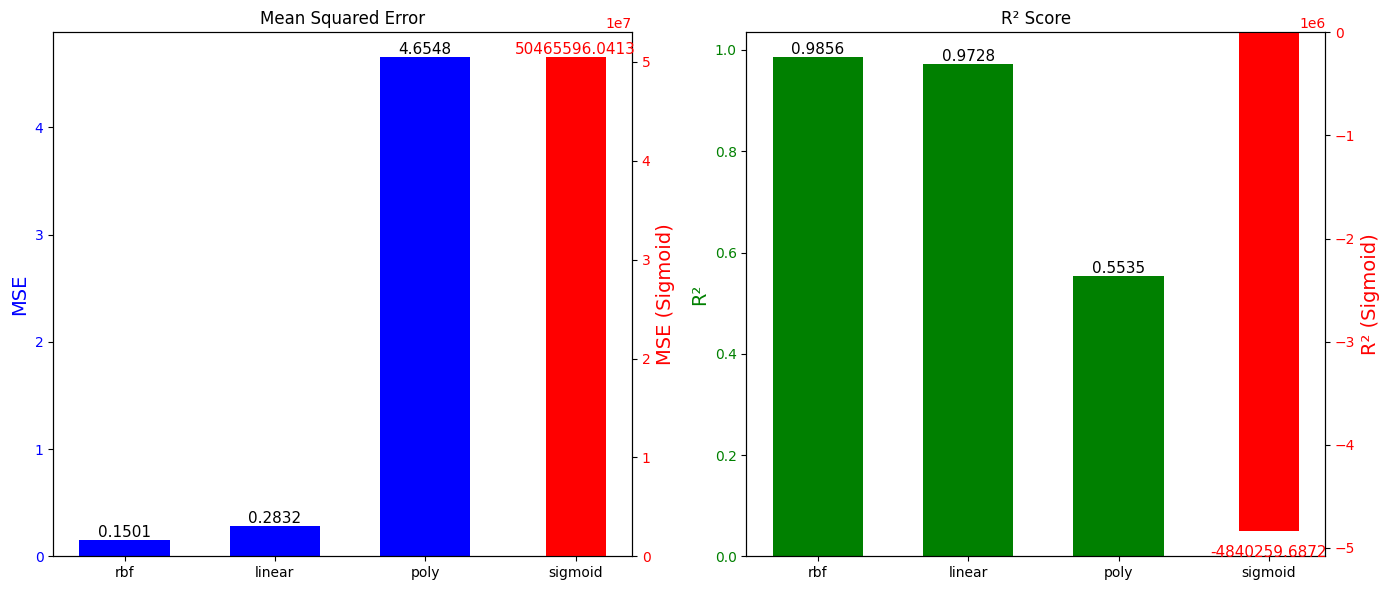

In [10]:
# -----------------------------------------------------------------------------
# Copyright (c) 2025 Renata Wong
#
# This code is supplementary material for the research paper:
# "Support Vector Machine Kernels as Quantum Propagators"
#
# Licensed under the MIT License.
# You may obtain a copy of the License at: https://opensource.org/licenses/MIT
# -----------------------------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os

# -----------------------------------------------------------------------------
# 1. LOAD DATA FROM CSV
# -----------------------------------------------------------------------------
csv_filename = "copper_materials_conductivity_proxy.csv"

if not os.path.exists(csv_filename):
    raise FileNotFoundError(f"Could not find {csv_filename}. Please ensure you have generated the dataset.")

print(f"Loading data from {csv_filename}...")
df = pd.read_csv(csv_filename)

# Display first few rows to verify
print("Data Sample:")
print(df[['Material', 'Eg_eV', 'Density_g_cm3', 'Log_Sigma']].head())

# -----------------------------------------------------------------------------
# 2. PREPARE FEATURES (X) AND TARGET (y)
# -----------------------------------------------------------------------------
# Features: Band Gap and Density
X = df[['Eg_eV', 'Density_g_cm3']].values

# Target: Log of Conductivity Proxy
y = df['Log_Sigma'].values

print(f"\nTotal samples: {len(X)}")

# -----------------------------------------------------------------------------
# 3. SPLIT AND SCALE
# -----------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit on training set, transform both
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale target (reshape needed for scaler)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# -----------------------------------------------------------------------------
# 4. TRAIN SVMs & COLLECT METRICS
# -----------------------------------------------------------------------------
kernels = ['rbf', 'linear', 'poly', 'sigmoid']
results = []

print("\n--- Training SVM Models ---")

for kernel in kernels:
    # Initialize SVR
    if kernel == 'poly':
        # Degree 3 is standard for physics approximations (e.g. anharmonic potentials)
        model = SVR(kernel=kernel, degree=3, C=100, gamma='scale')
    else:
        model = SVR(kernel=kernel, C=100, gamma='scale')

    # Train
    model.fit(X_train_scaled, y_train_scaled)
    
    # Predict
    y_pred_scaled = model.predict(X_test_scaled)

    # Inverse transform predictions to original scale (Log Sigma units)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    # Calculate Metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Kernel': kernel,
        'MSE': mse,
        'R2': r2
    })

# -----------------------------------------------------------------------------
# 5. OUTPUT VALUES (Text Table)
# -----------------------------------------------------------------------------
results_df = pd.DataFrame(results)
print("\n--- PERFORMANCE RESULTS ---")
print(results_df.round(4))

# Save results to CSV for record keeping
results_df.to_csv("svm_kernel_performance_metrics.csv", index=False)
print("\nMetrics saved to 'svm_kernel_performance_metrics.csv'")

# -----------------------------------------------------------------------------
# 6. PLOT RESULTS
# -----------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Prepare data for plotting
kernels_list = results_df['Kernel'].tolist()
mse_list = results_df['MSE'].tolist()
r2_list = results_df['R2'].tolist()

# --- Plot MSE ---
# We check if Sigmoid is an outlier to decide on dual axis
mse_max_others = max([m for k, m in zip(kernels_list, mse_list) if k != 'sigmoid'])
mse_sigmoid = results_df.loc[results_df['Kernel'] == 'sigmoid', 'MSE'].values[0]

# Plot others
others_mask = [k != 'sigmoid' for k in kernels_list]
ax1.bar(
    [k for k, m in zip(kernels_list, others_mask) if m], 
    [v for v, m in zip(mse_list, others_mask) if m], 
    color='b', width=0.6, label='Others'
)
ax1.set_ylabel('MSE', color='b', fontsize=14)
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("Mean Squared Error")

# Add value labels for others
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=11, color='black')

# Plot Sigmoid on twin axis
ax1_sig = ax1.twinx()
ax1_sig.bar(['sigmoid'], [mse_sigmoid], color='r', width=0.4, label='Sigmoid')
ax1_sig.set_ylabel('MSE (Sigmoid)', color='r', fontsize=14)
ax1_sig.tick_params(axis='y', labelcolor='r')

# Add value label for sigmoid
for p in ax1_sig.patches:
    ax1_sig.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=11, color='red')

# --- Plot R2 ---
r2_others = [r for k, r in zip(kernels_list, r2_list) if k != 'sigmoid']
r2_sigmoid = results_df.loc[results_df['Kernel'] == 'sigmoid', 'R2'].values[0]

# Plot others
ax2.bar(
    [k for k, m in zip(kernels_list, others_mask) if m], 
    [v for v, m in zip(r2_list, others_mask) if m], 
    color='green', width=0.6
)
ax2.set_ylabel('R²', color='green', fontsize=14)
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_title("R² Score")

# Add value labels
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=11, color='black')

# Plot Sigmoid on twin axis (often negative or very low)
ax2_sig = ax2.twinx()
ax2_sig.bar(['sigmoid'], [r2_sigmoid], color='r', width=0.4)
ax2_sig.set_ylabel('R² (Sigmoid)', color='r', fontsize=14)
ax2_sig.tick_params(axis='y', labelcolor='r')

# Add value label
for p in ax2_sig.patches:
    val = p.get_height()
    # Position text below bar if negative
    va = 'top' if val < 0 else 'bottom'
    offset = -10 if val < 0 else 5
    ax2_sig.annotate(f'{val:.4f}', (p.get_x() + p.get_width() / 2., val),
                     ha='center', va=va, xytext=(0, offset), 
                     textcoords='offset points', fontsize=11, color='red')

plt.tight_layout()
plt.savefig("svm_kernel_performance_csv.png")
plt.show()